<a href="https://colab.research.google.com/github/FredPedrosa/youtube_circumplex/blob/main/youtube_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-api-python-client
!pip install openpyxl

import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import pipeline
from googleapiclient.discovery import build
from google.colab import userdata
import nltk
from nltk.corpus import stopwords
# Configura o Pandas para mostrar barras de progresso
tqdm.pandas()


In [ ]:
# Carregar a chave da API do YouTube
YOUTUBE_API_KEY = userdata.get('YOUTUBE_API_KEY')
VIDEO_ID = 'Vz4Sb1bl1IE' # ID do v√≠deo (pode ser encontrado na URL do YouTube)

# Construir o servi√ßo da API
youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)

# Fun√ß√£o para coletar coment√°rios
def coletar_comentarios(video_id, limit=100):
    comments = []
    try:
        # Fazer a requisi√ß√£o inicial
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            maxResults=100 # M√°ximo por p√°gina
        ).execute()

        while response and len(comments) < limit:
            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']
                comments.append({
                    'author': comment['authorDisplayName'],
                    'published_at': comment['publishedAt'],
                    'text': comment['textDisplay'],
                    'like_count': comment['likeCount']
                })

            # Verificar se h√° uma pr√≥xima p√°gina e se ainda n√£o atingimos o limite
            if 'nextPageToken' in response and len(comments) < limit:
                response = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    textFormat='plainText',
                    pageToken=response['nextPageToken'],
                    maxResults=100
                ).execute()
            else:
                break

        return pd.DataFrame(comments)

    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return pd.DataFrame() # Retorna um DataFrame vazio em caso de erro

In [ ]:
import pandas as pd

# ---------------------------------------------------------------------------------
# PARTE 1: DEFINIR OS V√çDEOS E PAR√ÇMETROS DE COLETA
# ---------------------------------------------------------------------------------


# Dicion√°rio com listas de IDs de v√≠deo para cada fator
videos_por_fator = {
    'Movimento': [
        'CRCQ6Btlllc', # MC Tuto - Barbie (DJ Glenner)
        'H1DEczvTjgE' # Jo√£o Gomes - Meu peda√ßo de pecado
    ],
    'Tradi√ß√£o': [
        'U6reD8UVa0E', # Brenno & Matheus - Descer Pra BC
        '10XarNSkw0s', # Diego e Victor Hugo - Tubar√µes
    ],
    'Reflexo': [
        '9Sk7RQtSl5g', # ANAVIT√ìRIA, Vitor Kley - Pupila
        'W62-ZG9tPpI'  # TIAGO IORC - Amei Te Ver
    ],
    'Org√¢nico': [
        'Kt1MpsQ-jiA', # Cidade Negra - Girassol
        'i1Nm-MJ313w', # Natiruts - Quero Ser Feliz Tamb√©m
        'K2frSvI81Vk', # Tribo de Jah - Morena Raiz
        'kCE2d33yMNA'  # Maskavo - Um anjo do c√©u
    ],
    'Intenso': [
        'T1DJ2RdASWA', # Matanza - Bom √© Quando Faz Mal
        'TQ7V5tbX-DM', # Raimundos - Quero ver o Oco
        'nkmuqq4TBQ8', # Shaman - Carry On
        'nYc09Xqy3hE'  # Massacration - Evil papagali
    ]
}

# Definir o limite de coment√°rios a serem coletados por V√çDEO
# A cota da API do YouTube √© di√°ria e alta, ent√£o 5000 √© vi√°vel, mas pode demorar um pouco.
limite_por_video = 5000

# ---------------------------------------------------------------------------------
# PARTE 2: EXECU√á√ÉO DA COLETA
# ---------------------------------------------------------------------------------

# Lista para armazenar os DataFrames finais de cada fator
lista_de_dfs_geral = []

print("--- Iniciando coleta robusta de coment√°rios do YouTube ---")

# Loop principal: itera sobre cada fator (ex: 'Movimento')
for fator, lista_de_videos in videos_por_fator.items():
    print(f"\n----- Coletando para o Fator: {fator} -----")

    # Lista para armazenar os coment√°rios deste fator espec√≠fico
    comentarios_deste_fator = []

    # Loop secund√°rio: itera sobre cada v√≠deo DENTRO da lista do fator
    for video_id in lista_de_videos:
        print(f"  -> Coletando do v√≠deo ID: {video_id} (limite: {limite_por_video})")

        # Chama sua fun√ß√£o de coleta para este v√≠deo
        df_video_atual = coletar_comentarios(video_id, limit=limite_por_video)

        # Adiciona os coment√°rios coletados √† lista do fator
        if not df_video_atual.empty:
            comentarios_deste_fator.append(df_video_atual)
            print(f"     ...Coletados {len(df_video_atual)} coment√°rios.")
        else:
            print(f"     ...Nenhum coment√°rio coletado ou ocorreu um erro para o v√≠deo {video_id}.")

    # Verificar se coletamos algum coment√°rio para este fator
    if comentarios_deste_fator:
        # Juntar todos os DataFrames de coment√°rios deste fator em um s√≥
        df_fator_completo = pd.concat(comentarios_deste_fator, ignore_index=True)

        # Adicionar a coluna de identifica√ß√£o do fator
        df_fator_completo['fator_ritmo'] = fator

        # Adicionar o DataFrame deste fator √† nossa lista geral
        lista_de_dfs_geral.append(df_fator_completo)
        print(f"----- Total para o fator '{fator}': {len(df_fator_completo)} coment√°rios -----")

# ---------------------------------------------------------------------------------
# PARTE 3: FINALIZA√á√ÉO E SALVAMENTO
# ---------------------------------------------------------------------------------
if lista_de_dfs_geral:
    # Juntar todos os DataFrames de todos os fatores em um √∫nico DataFrame final
    df_final_youtube_robusto = pd.concat(lista_de_dfs_geral, ignore_index=True)

    # Salvar o dataset completo em um arquivo CSV
    df_final_youtube_robusto.to_csv('comentarios_youtube_robusto.csv', index=False)

    print("\n\n--- COLETA FINALIZADA ---")
    print(f"Total de coment√°rios coletados: {len(df_final_youtube_robusto)}")
    print("\nDistribui√ß√£o final de coment√°rios por fator:")
    display(df_final_youtube_robusto['fator_ritmo'].value_counts())
else:
    print("\n\n--- COLETA FINALIZADA ---")
    print("Nenhum coment√°rio foi coletado. Verifique os IDs dos v√≠deos e a conex√£o com a API.")

--- Iniciando coleta robusta de coment√°rios do YouTube ---

----- Coletando para o Fator: Movimento -----
  -> Coletando do v√≠deo ID: CRCQ6Btlllc (limite: 5000)
     ...Coletados 5000 coment√°rios.
  -> Coletando do v√≠deo ID: H1DEczvTjgE (limite: 5000)
     ...Coletados 5000 coment√°rios.
----- Total para o fator 'Movimento': 10000 coment√°rios -----

----- Coletando para o Fator: Tradi√ß√£o -----
  -> Coletando do v√≠deo ID: U6reD8UVa0E (limite: 5000)
     ...Coletados 5000 coment√°rios.
  -> Coletando do v√≠deo ID: 10XarNSkw0s (limite: 5000)
     ...Coletados 5000 coment√°rios.
----- Total para o fator 'Tradi√ß√£o': 10000 coment√°rios -----

----- Coletando para o Fator: Reflexo -----
  -> Coletando do v√≠deo ID: 9Sk7RQtSl5g (limite: 5000)
     ...Coletados 5000 coment√°rios.
  -> Coletando do v√≠deo ID: W62-ZG9tPpI (limite: 5000)
     ...Coletados 5000 coment√°rios.
----- Total para o fator 'Reflexo': 10000 coment√°rios -----

----- Coletando para o Fator: Org√¢nico -----
  -> Co

fator_ritmo
Intenso      12567
Org√¢nico     12102
Movimento    10000
Reflexo      10000
Tradi√ß√£o     10000
Name: count, dtype: int64

In [ ]:
# @title Balancear data set

import pandas as pd

# --------------------------------------------------------------------------
# PASSO 1: CARREGAR O DATASET COLETADO
# --------------------------------------------------------------------------
# Carregue o CSV que voc√™ gerou na coleta robusta
caminho_csv_robusto = 'comentarios_youtube_robusto.csv'
df_completo = pd.read_csv(caminho_csv_robusto)

print("--- Dataset Original ---")
print(f"Total de coment√°rios: {len(df_completo)}")
print("Distribui√ß√£o por fator:")
print(df_completo['fator_ritmo'].value_counts())


# --------------------------------------------------------------------------
# PASSO 2: PADRONIZAR O TAMANHO DA AMOSTRA (AMOSTRAGEM)
# --------------------------------------------------------------------------
# Definir o tamanho desejado para cada amostra de fator
tamanho_amostra = 10000

lista_dfs_balanceados = []
fatores_unicos = df_completo['fator_ritmo'].unique()

print(f"\n--- Padronizando para {tamanho_amostra} coment√°rios por fator ---")

for fator in fatores_unicos:
    # Filtrar o DataFrame para o fator atual
    df_fator_atual = df_completo[df_completo['fator_ritmo'] == fator]

    # Verificar se o n√∫mero de coment√°rios √© maior que o tamanho desejado
    if len(df_fator_atual) > tamanho_amostra:
        print(f"Fator '{fator}' tem {len(df_fator_atual)} coment√°rios. Reduzindo para {tamanho_amostra} atrav√©s de amostragem aleat√≥ria.")
        # .sample() pega uma amostra aleat√≥ria do DataFrame
        # n=tamanho_amostra -> define o tamanho da amostra
        # random_state=42 -> garante que a amostragem seja sempre a mesma se voc√™ rodar o c√≥digo de novo (reprodutibilidade)
        df_amostra_fator = df_fator_atual.sample(n=tamanho_amostra, random_state=42)
        lista_dfs_balanceados.append(df_amostra_fator)
    else:
        # Se o fator j√° tem 10.000 ou menos, usamos todos os seus coment√°rios
        print(f"Fator '{fator}' tem {len(df_fator_atual)} coment√°rios. Mantendo todos.")
        lista_dfs_balanceados.append(df_fator_atual)

# Juntar os DataFrames balanceados em um √∫nico DataFrame final
df_balanceado = pd.concat(lista_dfs_balanceados, ignore_index=True)


# --------------------------------------------------------------------------
# PASSO 3: VERIFICAR O RESULTADO FINAL
# --------------------------------------------------------------------------
print("\n--- Dataset Balanceado Final ---")
print(f"Total de coment√°rios ap√≥s balanceamento: {len(df_balanceado)}")
print("Nova distribui√ß√£o por fator:")
print(df_balanceado['fator_ritmo'].value_counts())

# A partir daqui, voc√™ usar√° o 'df_balanceado' para todas as an√°lises subsequentes
# (limpeza, contagem, visualiza√ß√£o, etc.)

--- Dataset Original ---
Total de coment√°rios: 54669
Distribui√ß√£o por fator:
fator_ritmo
Intenso      12567
Org√¢nico     12102
Movimento    10000
Reflexo      10000
Tradi√ß√£o     10000
Name: count, dtype: int64

--- Padronizando para 10000 coment√°rios por fator ---
Fator 'Movimento' tem 10000 coment√°rios. Mantendo todos.
Fator 'Tradi√ß√£o' tem 10000 coment√°rios. Mantendo todos.
Fator 'Reflexo' tem 10000 coment√°rios. Mantendo todos.
Fator 'Org√¢nico' tem 12102 coment√°rios. Reduzindo para 10000 atrav√©s de amostragem aleat√≥ria.
Fator 'Intenso' tem 12567 coment√°rios. Reduzindo para 10000 atrav√©s de amostragem aleat√≥ria.

--- Dataset Balanceado Final ---
Total de coment√°rios ap√≥s balanceamento: 50000
Nova distribui√ß√£o por fator:
fator_ritmo
Movimento    10000
Tradi√ß√£o     10000
Reflexo      10000
Org√¢nico     10000
Intenso      10000
Name: count, dtype: int64


In [ ]:
# @title *(Salvar e importar o data set balanceado)*

# Nome do arquivo que vamos criar
#arquivo_balanceado = 'comentarios_youtube_balanceado.csv'

# Salvar o DataFrame em um arquivo CSV no ambiente do Colab
#print(f"\nSalvando o DataFrame balanceado em '{arquivo_balanceado}'...")
#df_balanceado.to_csv(arquivo_balanceado, index=False)
#print("Arquivo salvo com sucesso!")

import pandas as pd

# Nome do arquivo que voc√™ acabou de fazer o upload
nome_arquivo_para_carregar = 'comentarios_youtube_balanceado.csv'

# Carregar o arquivo CSV para um DataFrame
try:
    # Vamos chamar a nova vari√°vel de 'df' para simplificar
    df = pd.read_csv(nome_arquivo_para_carregar)

    print("Dataset balanceado carregado com sucesso!")
    print(f"Total de linhas: {len(df)}")
    print("\nDistribui√ß√£o por fator:")
    print(df['fator_ritmo'].value_counts())

    print("\nAmostra dos dados:")
    display(df.head())

except FileNotFoundError:
    print(f"ERRO: Arquivo '{nome_arquivo_para_carregar}' n√£o encontrado.")
    print("Por favor, fa√ßa o upload do arquivo para o Colab antes de continuar.")

ERRO: Arquivo 'comentarios_youtube_balanceado.csv' n√£o encontrado.
Por favor, fa√ßa o upload do arquivo para o Colab antes de continuar.


In [ ]:
# --------------------------------------------------------------------------
# PASSO 1: CARREGAR O NOVO DATASET BALANCEADO
# --------------------------------------------------------------------------

df_robusto = df

# --------------------------------------------------------------------------
# PASSO 2: DEFINIR A FUN√á√ÉO DE LIMPEZA (A MESMA DE ANTES)
# --------------------------------------------------------------------------
def limpar_texto(texto):
    if not isinstance(texto, str):
        return "" # Retorna uma string vazia se o texto n√£o for uma string
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'\@\w+|\#\w+', '', texto)
    texto = texto.lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = re.sub(r'\d+', '', texto)
    texto = " ".join(texto.split())
    return texto

# --------------------------------------------------------------------------
# PASSO 3: CRIAR A LISTA DE STOPWORDS ABRANGENTE E ATUALIZADA
# --------------------------------------------------------------------------
print("\nPreparando a lista de stopwords atualizada...")
try:
    portuguese_stops = set(stopwords.words('portuguese'))
except LookupError:
    nltk.download('stopwords')
    portuguese_stops = set(stopwords.words('portuguese'))

# Palavras gen√©ricas para ignorar
palavras_extras_gerais = {
    'm√∫sica', 'som', 'letra', 'clipe', 'video', 'gente', 't√°', 'n√©', 'faz', 'ver', 'sempre',
    'ainda', 'tudo', 'coisa', 'dia', 'dms', 'aqui', 'pra', 'vou', 'vai', 'ser', 'ter',
    'quer', 'mim', 'bem', 'agora', 't√£o', 's√≥', 'jao', 'pro', 'vc', 'mt', 'td'
}

# Palavras espec√≠ficas do contexto dos NOVOS v√≠deos
stopwords_contexto_novo = {
    # Movimento
    'tuto', 'glenner', 'barbie', 'nilo', 'paiva', 'marques', 'fuimlk', 'mlk',
    'ahn', 'jo√£o', 'gomes', 'duas', 'cara', 'achava', 'senta', 'n√≥is',
    'manh√£', 'dessa', 'querendo', 'putinhas', 'sabe', 'nesse', 'dar',
    'ouvir', 'toma', 'moleque', 'canta', 'lindinhas', 'joga', 'fim', 'valentino',
    'sexta', 'pique', 'outra', 'sentar','puxa', 'semana', 'drake','champanhe',
    'bigode', 'quarto',
    # Tradi√ß√£o
    'brenno', 'matheus', 'descer', 'bc', 'simone', 'mendes', 'saudade', 'proibida',
    'musica', 'tubar√µes', 'deixou', 'devo', 'deve', 'explica√ß√µes',
    'demais', 'sucesso', 'mar', 'ano', 'vcs', 'saber', 'nessa', 'dessa', 'nao',
    'pergunte', 'direito', 'vida','ficou', 'todo', 'perguntar', 'parte','rolou',
    '‚ù§‚ù§‚ù§', 'hugo', 'diego', 'victor','vezes','dupla','vim',
    # Reflexo
    'anavitoria', 'anavit√≥ria', 'vitor', 'kley', 'pupila', 'lagum', 'iza',
    'bom', 'parab√©ns', 'algu√©m', 'dizer', 'quase', 'boa', 'bruna', 'anos',
    'dilatar', 'demais', 'tempo', 'tiago', 'fez', 'dessa', 'sei', 'ningu√©m', 'melhor',
    'cheiro', 'quanto', 'trope√ßa', 'sai', 'escutando', 'lindo', 'v√≠deo',
    'tanto', 'vez', 'cor', 'tatata', 'clip', 'pessoa', 'cabelo', 'marquezine',
    'passa',  'rima', 'porque', 'quarentena',
    # Org√¢nico
    'cidade', 'negra', 'girassol', 'natiruts', 'algu√©m', 'ouvindo', 'quero',
    'brasil', 'vem', 'todos', 'reggae', 'banda', 'm√∫sicas', 'dessa', 'hoje',
    'anjo', 'toda', 'can√ß√£o',
    # Intenso
    'torture', 'squad', 'fallen', 'ones', 'matanza', 'mal', 'raimundos', 'oco',
    'shaman', 'carry', 'rock', 'banda', 'the', 'metal', 'cara', 'loro',
    'biscoito', 'quero', 'massacration', 'algu√©m', 'rodolfo', 'rip', 'matos',
    'andr√©', 'porra', 'l√¥ro', 'andre', 'nao', 'caralho', 'nunca', 'your', 'puta',
    'canisso', 'kkkk', 'dessa', 'bandas', 'caras', 'angra', 'and', 'you', 'kkk',
    'heavy', 'ouvir', 'kkkkk', 'saudades', 'from', 'mundo',  'mano', 'melhores',
    'fazer', 'guitarra','vendo', 'pai', 'power', 'assim', 'acho','evil','dentro',
    'papagali'
}

# Juntar todas as stopwords em uma √∫nica lista
portuguese_stops.update(palavras_extras_gerais)
portuguese_stops.update(stopwords_contexto_novo)
print("Lista de stopwords atualizada e pronta.")


# --------------------------------------------------------------------------
# PASSO 4: APLICAR A LIMPEZA NO NOVO DATAFRAME
# --------------------------------------------------------------------------
print("\nAplicando a limpeza nos coment√°rios...")
df_robusto['texto_limpo'] = df_robusto['text'].apply(limpar_texto)
print("Coluna 'texto_limpo' criada.")


# --------------------------------------------------------------------------
# PASSO 5: RODAR A AN√ÅLISE DE FREQU√äNCIA POR FATOR (SEU C√ìDIGO)
# --------------------------------------------------------------------------
# Agora, o seu c√≥digo de an√°lise de frequ√™ncia vai funcionar perfeitamente
# com o novo DataFrame 'df_robusto' e a lista de stopwords atualizada.

# O nome do DataFrame agora √© 'df_robusto'
fatores_unicos = df_robusto['fator_ritmo'].unique()
resultados_por_fator = {}

print("\n--- Iniciando an√°lise de frequ√™ncia de palavras para cada fator RITMO (Amostra Robusta) ---")
for fator in fatores_unicos:
    print(f"\n----- Analisando Fator: {fator} -----")
    df_subset = df_robusto[df_robusto['fator_ritmo'] == fator]
    textao_fator = " ".join(df_subset['texto_limpo'].dropna()) # .dropna() para seguran√ßa
    lista_de_palavras_fator = [
        palavra for palavra in textao_fator.split()
        if palavra not in portuguese_stops and len(palavra) > 2
    ]
    contagem_palavras_fator = Counter(lista_de_palavras_fator)
    resultados_por_fator[fator] = contagem_palavras_fator

    numero_de_palavras_para_mostrar = 20 # Aumentei para 20
    print(f"As {numero_de_palavras_para_mostrar} palavras mais comuns para '{fator}':")
    print(contagem_palavras_fator.most_common(numero_de_palavras_para_mostrar))


Preparando a lista de stopwords atualizada...
Lista de stopwords atualizada e pronta.

Aplicando a limpeza nos coment√°rios...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Coluna 'texto_limpo' criada.

--- Iniciando an√°lise de frequ√™ncia de palavras para cada fator RITMO (Amostra Robusta) ---

----- Analisando Fator: Movimento -----
As 20 palavras mais comuns para 'Movimento':
[('amo', 442), ('voz', 368), ('gata', 318), ('linda', 281), ('top', 266), ('deus', 251), ('show', 230), ('gosto', 147), ('vaqueiro', 146), ('charmosa', 142), ('amiga', 138), ('louco', 136), ('dan√ßando', 133), ('novo', 131), ('rico', 131), ('maravilha', 130), ('chique', 130), ('maloqueiro', 128), ('limpa', 121), ('cansou', 121)]

----- Analisando Fator: Tradi√ß√£o -----
As 20 palavras mais comuns para 'Tradi√ß√£o':
[('top', 306), ('amor', 279), ('amo', 219), ('linda', 210), ('ruim', 190), ('amei', 145), ('inferno', 119), ('deus', 116), ('comigo', 113), ('perfeita', 110), ('viciada', 100), ('voz', 95), ('moda', 94), ('recorda√ß√µes', 94), ('gostei', 90), ('pedrada', 90), ('nada', 86), ('show', 83), ('pancada', 81), ('lixo', 77)]

----- Analisando Fator: Reflexo -----
As 20 palavra

In [ ]:
# @title Carregar e preparar o ANEW-BR

caminho = '/content/ANEW_BR.xlsx'
df_lexico = pd.read_excel(caminho)

print("Arquivo Excel carregado.")
print(f"N√∫mero inicial de linhas: {len(df_lexico)}")

# --- AJUSTE DOS NOMES DAS COLUNAS ---
coluna_palavra = 'Word'
coluna_valencia = 'Val_mean'
coluna_ativacao = 'Aro_mean'

# --------------------------------------------------------------------------
# --- Passo 1: Limpeza e Padroniza√ß√£o ---
# --------------------------------------------------------------------------


# Colocar a coluna de palavras em min√∫sculas
df_lexico[coluna_palavra] = df_lexico[coluna_palavra].str.lower()

# --------------------------------------------------------------------------
# --- Passo 2: Identificar e Remover TODAS as Ocorr√™ncias de Duplicatas (Sua Escolha) ---
# --------------------------------------------------------------------------

# Verificar o n√∫mero de linhas antes da remo√ß√£o
num_linhas_antes = len(df_lexico)

# O m√©todo .drop_duplicates() com keep=False remove TODAS as linhas que s√£o duplicadas.
# Isso significa que se uma palavra aparece 2 ou mais vezes, todas as suas entradas ser√£o removidas.
print("\nRemovendo todas as ocorr√™ncias de palavras duplicadas...")
df_lexico.drop_duplicates(subset=[coluna_palavra], keep=False, inplace=True)

# Verificar o n√∫mero de linhas ap√≥s a remo√ß√£o
num_linhas_depois = len(df_lexico)
print(f"N√∫mero de linhas ap√≥s a remo√ß√£o completa das duplicatas: {num_linhas_depois}")
print(f"Total de {num_linhas_antes - num_linhas_depois} linhas associadas a duplicatas foram removidas.")

# --------------------------------------------------------------------------
# --- Passo 3: Criar o Dicion√°rio (Com um l√©xico mais enxuto e sem ambiguidades) ---
# --------------------------------------------------------------------------

# Definir a palavra como o √≠ndice do DataFrame (agora garantidamente √∫nico)
df_lexico.set_index(coluna_palavra, inplace=True)

# Criar o dicion√°rio no formato {palavra: (valencia, ativacao)}
lexico_anew_br = {
    palavra: (valores[coluna_valencia], valores[coluna_ativacao])
    for palavra, valores in df_lexico.to_dict('index').items()
}

print("\nDicion√°rio do l√©xico criado com sucesso!")

# Exibir um exemplo para confirmar
print("Exemplo do dicion√°rio: 'amor' ->", lexico_anew_br.get('amor'))
print("Exemplo do dicion√°rio: 'triste' ->", lexico_anew_br.get('triste'))

Arquivo Excel carregado.
N√∫mero inicial de linhas: 1046

Removendo todas as ocorr√™ncias de palavras duplicadas...
N√∫mero de linhas ap√≥s a remo√ß√£o completa das duplicatas: 1044
Total de 2 linhas associadas a duplicatas foram removidas.

Dicion√°rio do l√©xico criado com sucesso!
Exemplo do dicion√°rio: 'amor' -> (8.75, 4.39)
Exemplo do dicion√°rio: 'triste' -> (1.73, 5.28)


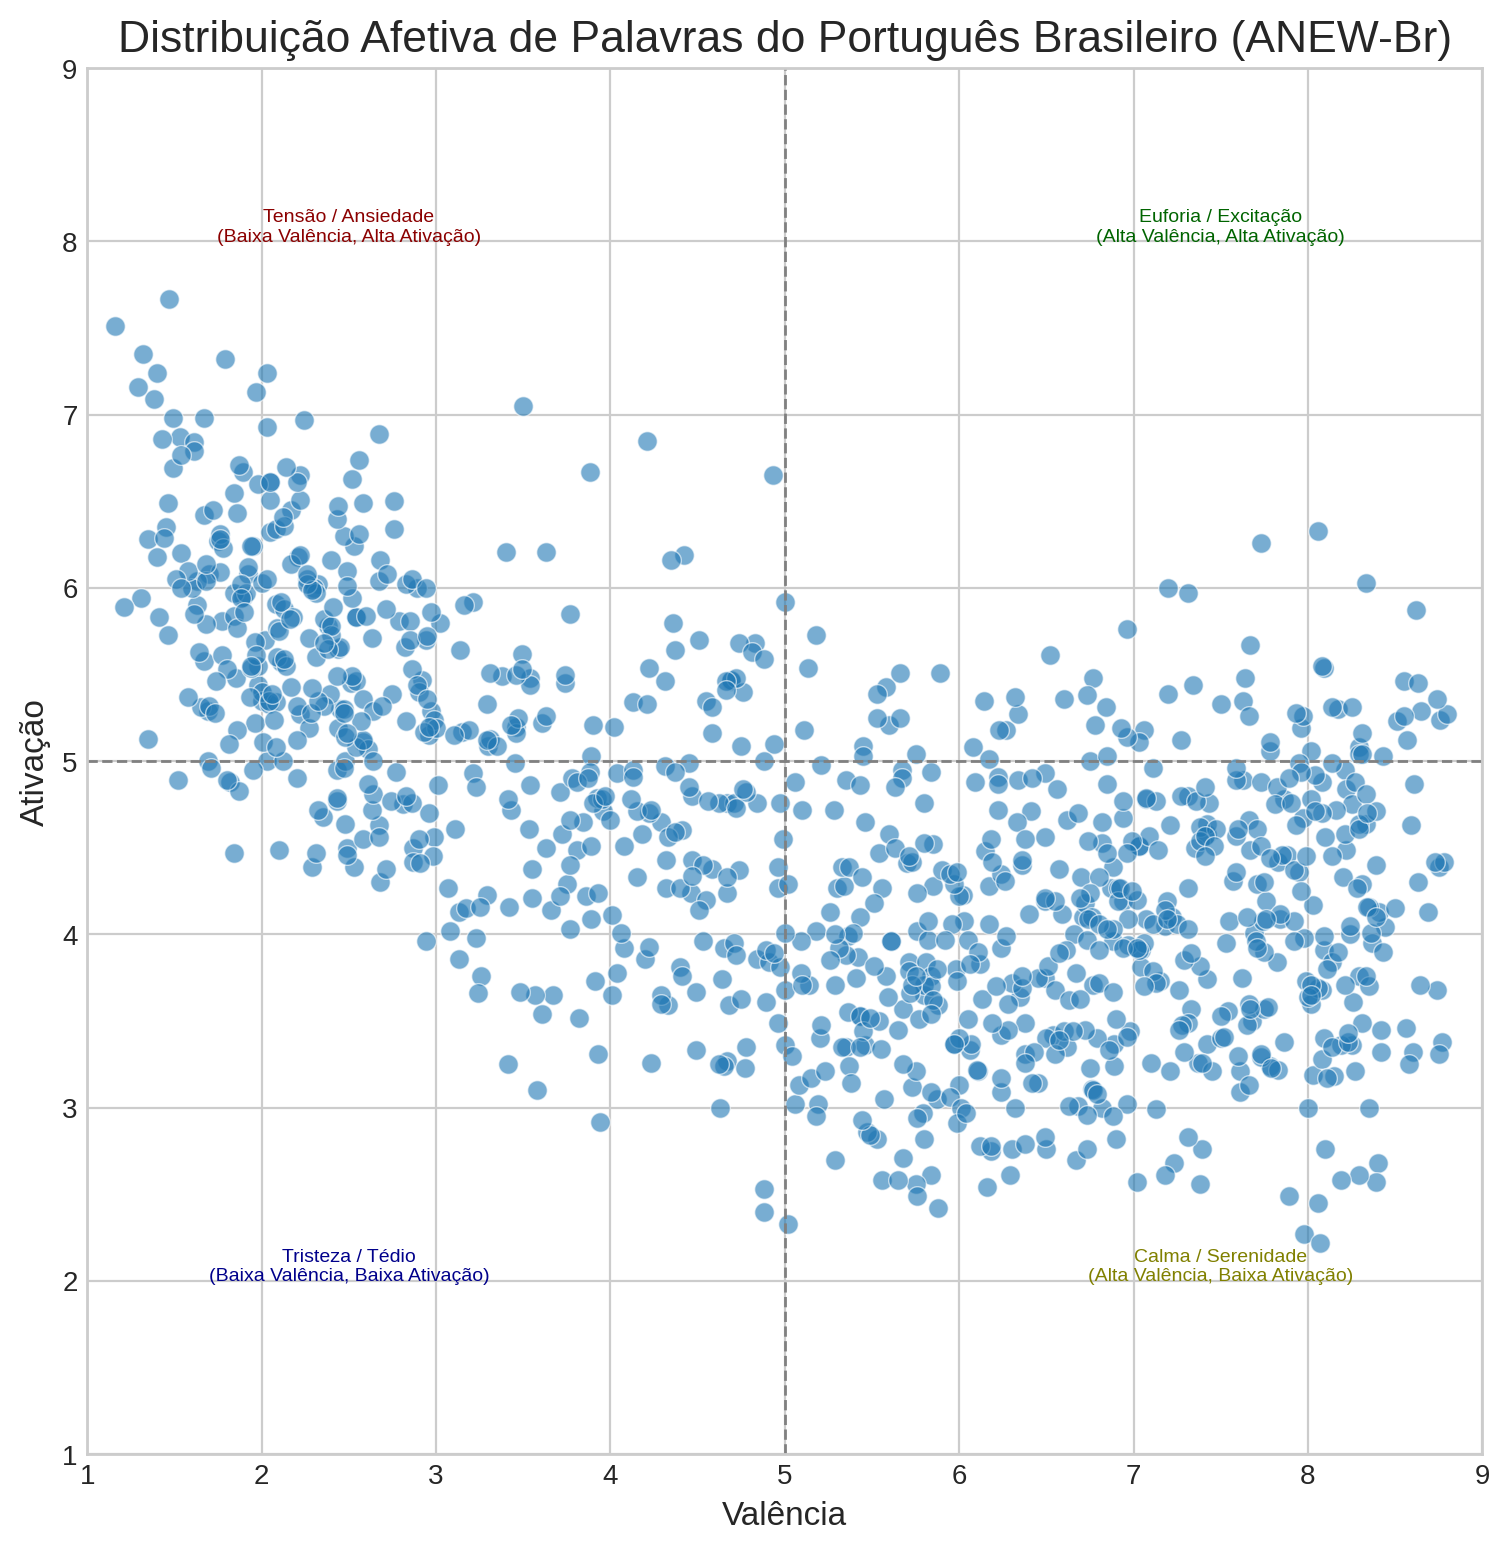

In [ ]:
# @title Visualiza√ß√£o da distribui√ß√£o em 2D do ANEW-BR
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns

 #1. Configurar o estilo e o tamanho da figura
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(9, 9)) # Deixei quadrado para o aspecto ficar melhor

# 2. Criar o gr√°fico de dispers√£o (scatter plot) com os eixos trocados
sns.scatterplot(
    data=df_lexico,
    x=coluna_valencia,
    y=coluna_ativacao,
    alpha=0.6,
    s=50,
    edgecolor='w',
    linewidth=0.5
)

# 3. Adicionar linhas de refer√™ncia para os quadrantes
# A linha vertical (x=5) agora corta o eixo de Val√™ncia.
# A linha horizontal (y=5) agora corta o eixo de Ativa√ß√£o.
plt.axvline(x=5, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=5, color='gray', linestyle='--', linewidth=1)

# 4. CORRIGIR as coordenadas das anota√ß√µes para os quadrantes
# As coordenadas (x, y) agora correspondem a (val√™ncia, ativa√ß√£o)
# Quadrante Superior Esquerdo: Baixa Val√™ncia, Alta Ativa√ß√£o
plt.text(2.5, 8.0, 'Tens√£o / Ansiedade\n(Baixa Val√™ncia, Alta Ativa√ß√£o)', fontsize=7, ha='center', color='darkred')
# Quadrante Superior Direito: Alta Val√™ncia, Alta Ativa√ß√£o
plt.text(7.5, 8.0, 'Euforia / Excita√ß√£o\n(Alta Val√™ncia, Alta Ativa√ß√£o)', fontsize=7, ha='center', color='darkgreen')
# Quadrante Inferior Esquerdo: Baixa Val√™ncia, Baixa Ativa√ß√£o
plt.text(2.5, 2.0, 'Tristeza / T√©dio\n(Baixa Val√™ncia, Baixa Ativa√ß√£o)', fontsize=7, ha='center', color='darkblue')
# Quadrante Inferior Direito: Alta Val√™ncia, Baixa Ativa√ß√£o
plt.text(7.5, 2.0, 'Calma / Serenidade\n(Alta Val√™ncia, Baixa Ativa√ß√£o)', fontsize=7, ha='center', color='olive')


# 5. CORRIGIR os r√≥tulos (labels) dos eixos
plt.title('Distribui√ß√£o Afetiva de Palavras do Portugu√™s Brasileiro (ANEW-Br)', fontsize=16)
plt.xlabel('Val√™ncia', fontsize=12) # Eixo X √© Val√™ncia
plt.ylabel('Ativa√ß√£o', fontsize=12) # Eixo Y √© Ativa√ß√£o

# 6. Definir os limites dos eixos para que fiquem bem enquadrados
plt.xlim(1, 9)
plt.ylim(1, 9)

#nome_do_arquivo = 'grafico_anew_alta_resolucao.png'
#plt.savefig(nome_do_arquivo, dpi=2400, bbox_inches='tight')

# 7. Exibir o gr√°fico
plt.show()

In [ ]:
# Lista para armazenar os resultados da an√°lise quantitativa
perfis_afetivos = []

print("--- Calculando o Perfil Afetivo M√©dio Ponderado para cada Fator ---")

for fator, contagem_de_palavras in resultados_por_fator.items():

    # Listas para guardar os valores ponderados para este fator
    valencias_ponderadas = []
    ativacoes_ponderadas = []
    pesos_totais = 0

    for palavra, frequencia in contagem_de_palavras.items():
        if palavra in lexico_anew_br:
            valencia, ativacao = lexico_anew_br[palavra]

            # Adicionar o valor multiplicado pela frequ√™ncia (peso)
            valencias_ponderadas.append(valencia * frequencia)
            ativacoes_ponderadas.append(ativacao * frequencia)
            pesos_totais += frequencia

    # Calcular a m√©dia ponderada, se tivermos encontrado alguma palavra no l√©xico
    if pesos_totais > 0:
        valencia_media_ponderada = sum(valencias_ponderadas) / pesos_totais
        ativacao_media_ponderada = sum(ativacoes_ponderadas) / pesos_totais

        perfis_afetivos.append({
            'Fator_RITMO': fator,
            'Valencia_Media': valencia_media_ponderada,
            'Ativacao_Media': ativacao_media_ponderada,
            'Total_Palavras_Mapeadas': pesos_totais
        })

# Criar um DataFrame com o resumo
df_perfil_afetivo = pd.DataFrame(perfis_afetivos)

print("\n--- Resultado da An√°lise Quantitativa ---")
display(df_perfil_afetivo.sort_values(by='Ativacao_Media', ascending=False))

--- Calculando o Perfil Afetivo M√©dio Ponderado para cada Fator ---

--- Resultado da An√°lise Quantitativa ---


Fator_RITMO  Valencia_Media  Ativacao_Media  Total_Palavras_Mapeadas
1    Tradi√ß√£o        6.374217        4.574640                     2623
0   Movimento        6.784942        4.354904                     3422
2     Reflexo        7.234299        4.346802                     3724
4     Intenso        6.380653        4.344265                     3245
3    Org√¢nico        7.321909        4.263644                     4394

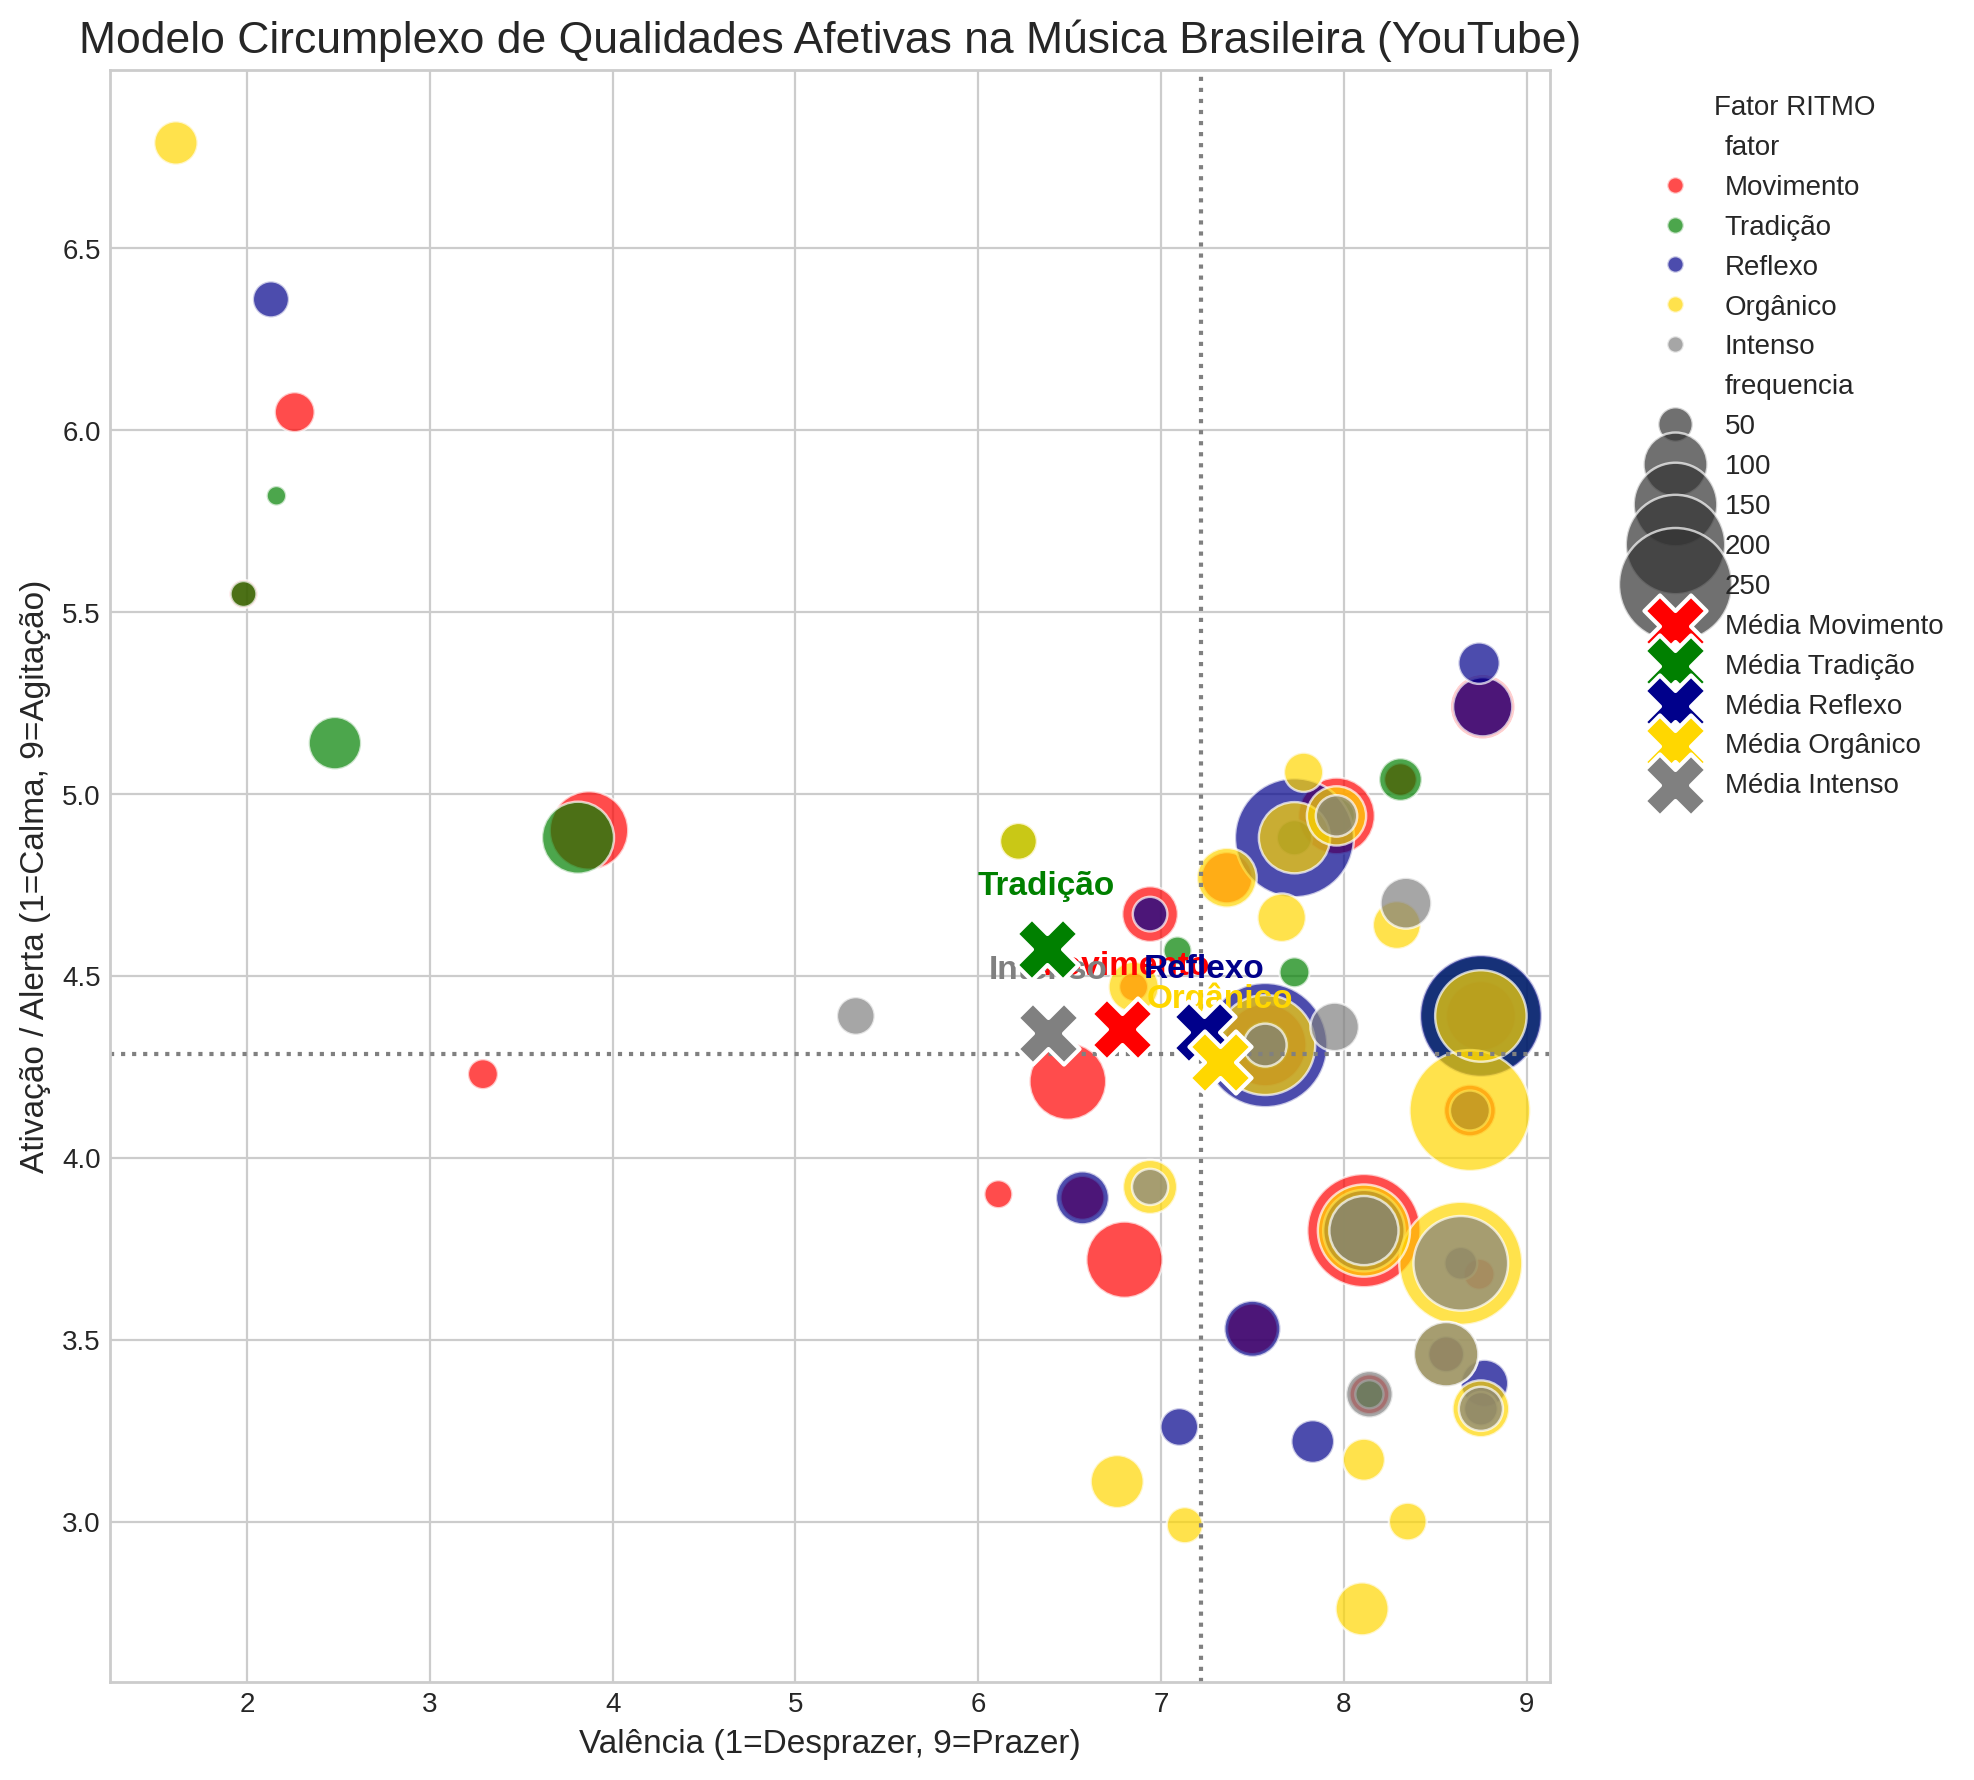

In [ ]:
# --- PARTE A: Preparar os dados para o plot ---

dados_para_plotar = []
# Loop para passar por cada fator (Movimento, Reflexo, etc.)
for fator, contagem_de_palavras in resultados_por_fator.items():
    # Loop para passar pelas palavras mais comuns daquele fator
    for palavra, frequencia in contagem_de_palavras.most_common(100):
        # Verificar se a palavra existe no nosso l√©xico
        if palavra in lexico_anew_br:
            # Pegar os valores de val√™ncia e ativa√ß√£o do l√©xico
            valencia, ativacao = lexico_anew_br[palavra]
            # Adicionar tudo a nossa lista de dados prontos
            dados_para_plotar.append({
                'fator': fator,
                'palavra': palavra,
                'frequencia': frequencia,
                'valencia': valencia,
                'ativacao': ativacao
            })

# Converter a lista em um DataFrame do Pandas para facilitar a visualiza√ß√£o
df_plot_final = pd.DataFrame(dados_para_plotar)


# --- PARTE B: Criar a visualiza√ß√£o com cores personalizadas ---

# Verificar se temos dados para plotar
if df_plot_final.empty:
    print("Nenhum dado para plotar. Verifique seu l√©xico e suas contagens.")
else:
    # 1. Definir a nossa paleta de cores personalizada
    # Usaremos um dicion√°rio: {Nome do Fator: 'cor'}
    cores_personalizadas = {
        'Movimento': 'red',     # Vermelho para um fator energ√©tico
        'Reflexo':   'darkblue',  # Azul escuro para um fator mais introspectivo
        'Tradi√ß√£o':  'green',   # Verde, talvez associado a algo mais tradicional/raiz
        'Intenso':   'gray',   # Preto ou cinza escuro para o fator Intenso
        'Org√¢nico':  'gold'      # Amarelo/dourado para algo mais "org√¢nico"/ac√∫stico
    }

    # 2. Configurar o gr√°fico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 9))

    # 3. Plotar as nuvens de palavras usando a paleta personalizada
    sns.scatterplot(
        data=df_plot_final,
        x='valencia',
        y='ativacao',
        hue='fator',       # A cor ainda √© baseada no fator...
        palette=cores_personalizadas, # ...mas agora usamos nosso dicion√°rio de cores!
        size='frequencia',
        sizes=(50, 2000),
        alpha=0.7,
        ax=ax
    )

    # 4. Plotar os "centros de gravidade"
    # Vamos usar as mesmas cores para os marcadores de m√©dia para consist√™ncia
    for fator_nome in df_perfil_afetivo['Fator_RITMO'].unique():
        # Filtrar o DataFrame de perfis para o fator atual
        perfil = df_perfil_afetivo[df_perfil_afetivo['Fator_RITMO'] == fator_nome]

        if not perfil.empty:
            ax.scatter(
                x=perfil['Valencia_Media'],
                y=perfil['Ativacao_Media'],
                marker='X',
                s=500,
                color=cores_personalizadas.get(fator_nome, 'gray'), # Pega a cor do dicion√°rio
                edgecolor='white', # Adiciona uma borda branca para destacar
                linewidth=1.5,
                label=f'M√©dia {fator_nome}', # Adiciona √† legenda
                zorder=10 # Garante que fique por cima dos outros pontos
            )
            ax.text(
                x=perfil['Valencia_Media'].values[0],
                y=perfil['Ativacao_Media'].values[0] + 0.15,
                s=fator_nome, # Apenas o nome do fator
                color=cores_personalizadas.get(fator_nome, 'gray'),
                ha='center',
                weight='bold',
                fontsize=12
            )

    # 5. Configura√ß√µes finais do gr√°fico
    ax.axhline(df_plot_final['ativacao'].mean(), color='gray', linestyle=':')
    ax.axvline(df_plot_final['valencia'].mean(), color='gray', linestyle=':')
    ax.set_xlabel('Val√™ncia (1=Desprazer, 9=Prazer)', fontsize=12)
    ax.set_ylabel('Ativa√ß√£o / Alerta (1=Calma, 9=Agita√ß√£o)', fontsize=12)
    ax.set_title('Modelo Circumplexo de Qualidades Afetivas na M√∫sica Brasileira (YouTube)', fontsize=16)

    # Melhorar a legenda
    handles, labels = ax.get_legend_handles_labels()
    # Manter apenas as legendas dos fatores principais na legenda
    # (Isso evita que cada ponto de m√©dia crie uma nova entrada na legenda)
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), title='Fator RITMO', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


Calculando os perfis afetivos m√©dios...
DataFrame 'df_perfil_afetivo' criado com sucesso.

Gerando a visualiza√ß√£o final...


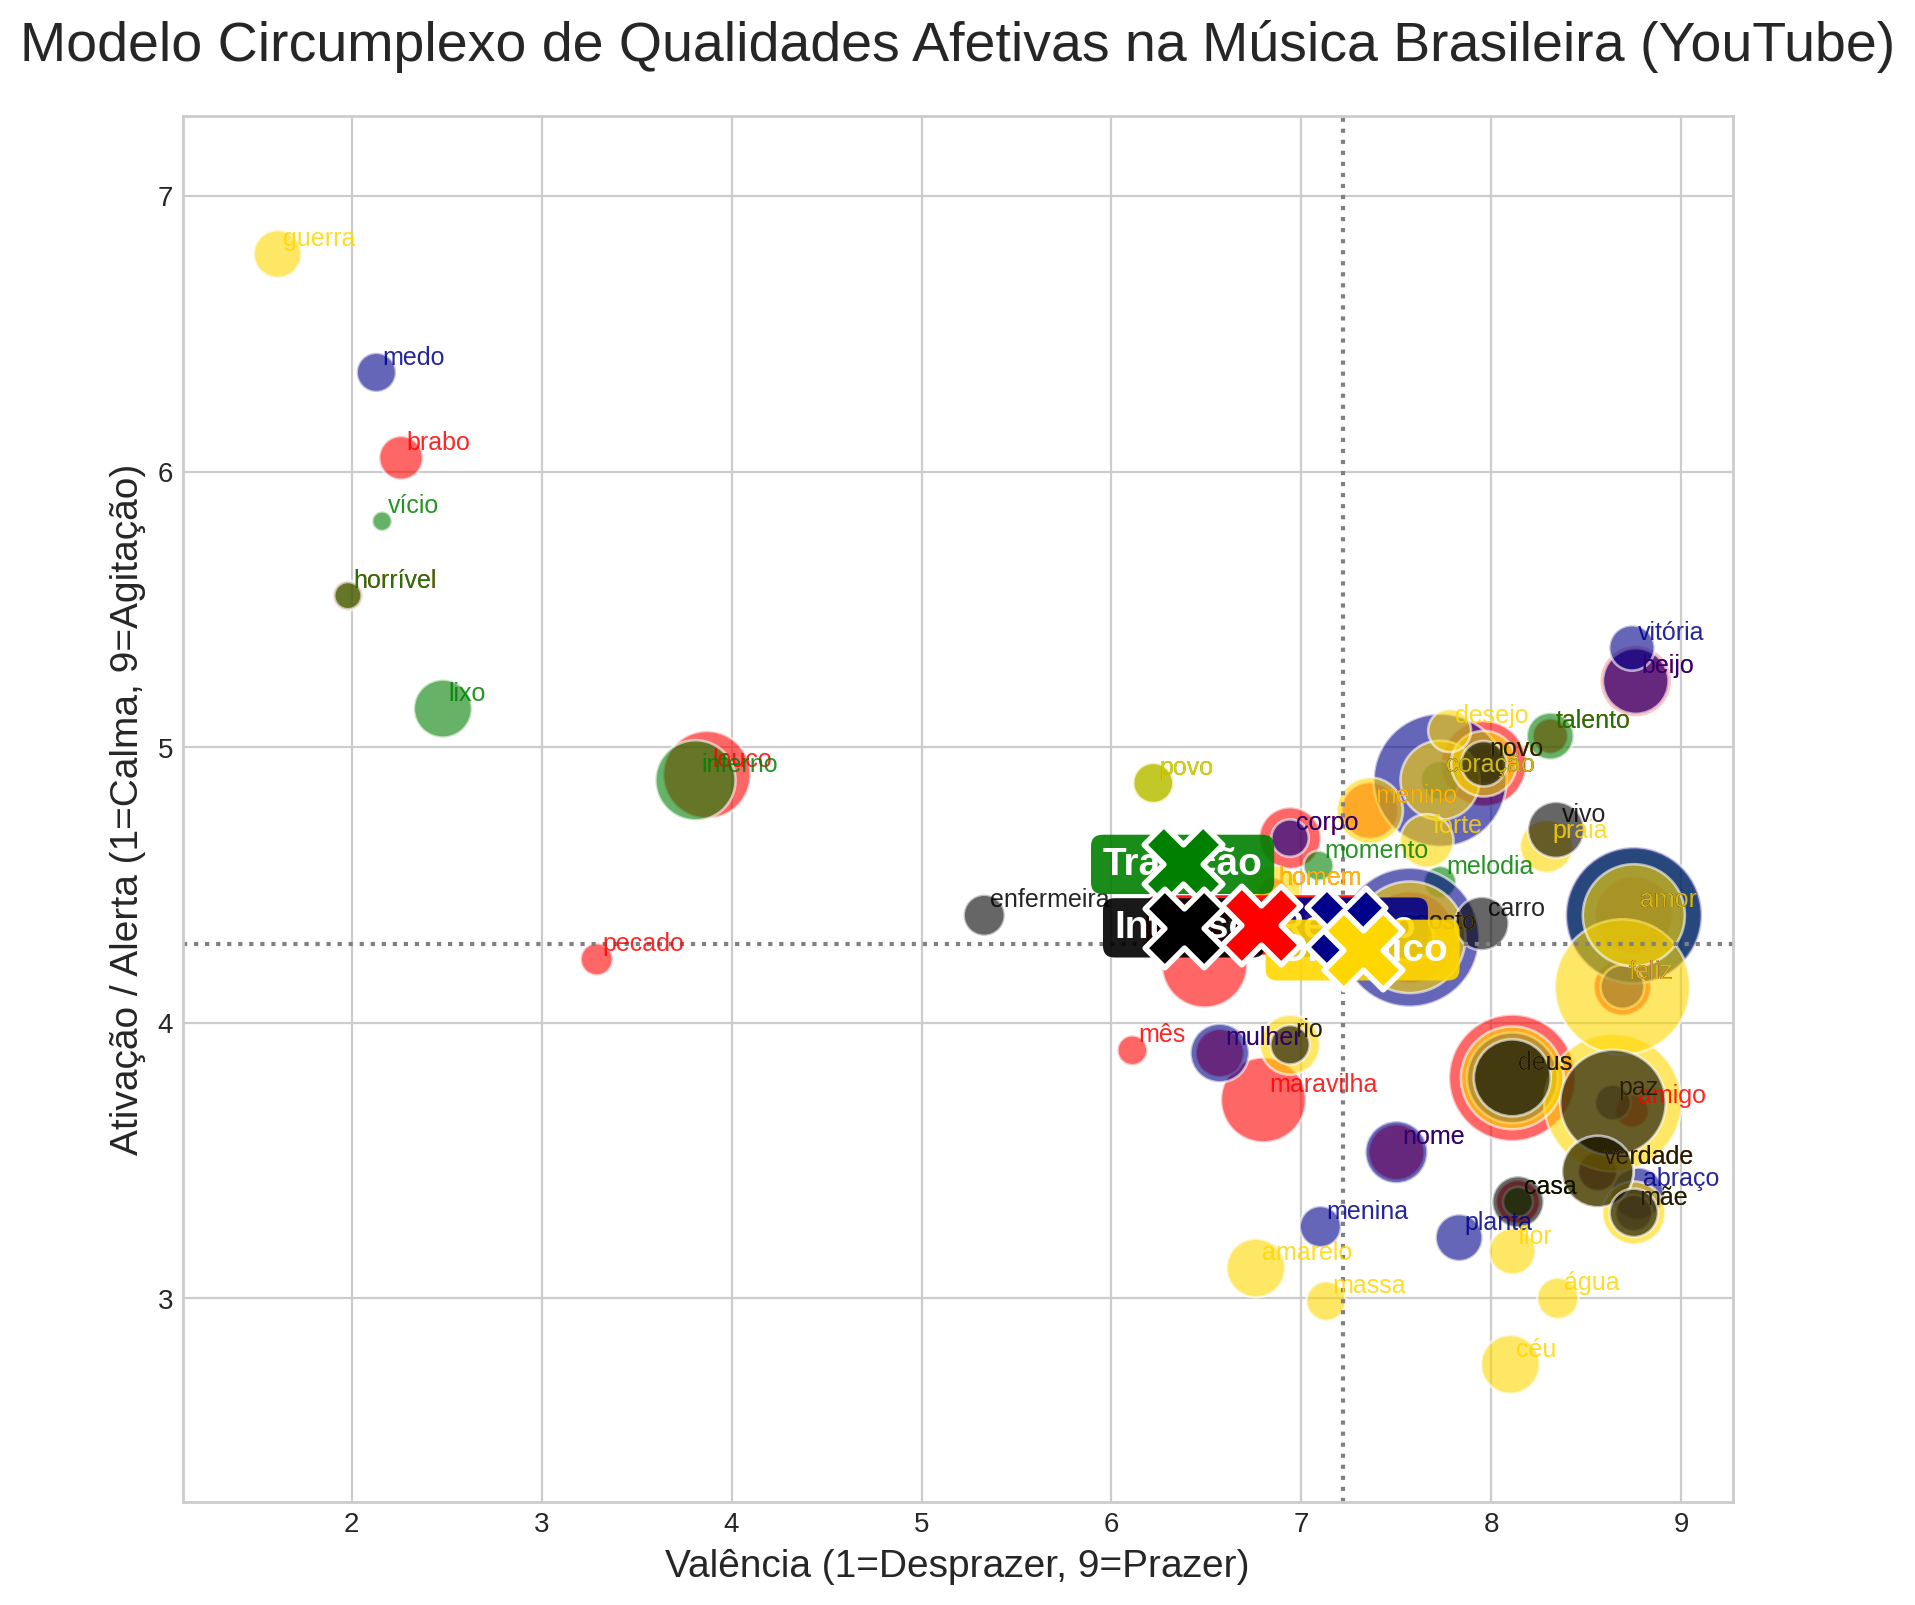

In [ ]:
# --- PARTE 2: CRIAR o DataFrame 'df_perfil_afetivo' ---
# Este bloco calcula as m√©dias ponderadas.

print("\nCalculando os perfis afetivos m√©dios...")
perfis_afetivos = []
for fator, contagem_de_palavras in resultados_por_fator.items():
    valencias_ponderadas = []
    ativacoes_ponderadas = []
    pesos_totais = 0
    for palavra, frequencia in contagem_de_palavras.items():
        if palavra in lexico_anew_br:
            valencia, ativacao = lexico_anew_br[palavra]
            valencias_ponderadas.append(valencia * frequencia)
            ativacoes_ponderadas.append(ativacao * frequencia)
            pesos_totais += frequencia
    if pesos_totais > 0:
        valencia_media_ponderada = sum(valencias_ponderadas) / pesos_totais
        ativacao_media_ponderada = sum(ativacoes_ponderadas) / pesos_totais
        perfis_afetivos.append({
            'Fator_RITMO': fator,
            'Valencia_Media': valencia_media_ponderada,
            'Ativacao_Media': ativacao_media_ponderada
        })
df_perfil_afetivo = pd.DataFrame(perfis_afetivos)
print("DataFrame 'df_perfil_afetivo' criado com sucesso.")


# --- PARTE 3: CRIAR a Visualiza√ß√£o (O c√≥digo que voc√™ j√° tem) ---
# Agora este bloco vai funcionar, pois 'df_plot_final' e 'df_perfil_afetivo' existem.

print("\nGerando a visualiza√ß√£o final...")
if df_plot_final.empty:
    print("Nenhum dado para plotar. Verifique seu l√©xico e suas contagens.")
else:
    # (Cole aqui o c√≥digo de visualiza√ß√£o que eu te passei na √∫ltima mensagem,
    #  come√ßando pela defini√ß√£o de 'cores_personalizadas' e 'plt.style.use'...)
    # 1. Definir a paleta de cores personalizada
    cores_personalizadas = {
        'Movimento': 'red', 'Reflexo': 'darkblue', 'Tradi√ß√£o': 'green',
        'Intenso': 'black', 'Org√¢nico': 'gold'
    }

    # 2. Configurar o gr√°fico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 9))

    # 3. Plotar as nuvens de palavras SEM a legenda autom√°tica
    sns.scatterplot(
        data=df_plot_final, x='valencia', y='ativacao', hue='fator',
        palette=cores_personalizadas, size='frequencia', sizes=(50, 2500),
        alpha=0.6, ax=ax, legend=False
    )

    # 4. Adicionar o nome de cada palavra no gr√°fico
    for index, row in df_plot_final.iterrows():
        ax.text(
            x=row['valencia'] + 0.03, y=row['ativacao'] + 0.03, s=row['palavra'],
            fontdict=dict(color=cores_personalizadas.get(row['fator']), size=9, alpha=0.85)
        )

    # 5. Plotar e rotular os "centros de gravidade"
    for fator_nome in df_perfil_afetivo['Fator_RITMO'].unique():
        perfil = df_perfil_afetivo[df_perfil_afetivo['Fator_RITMO'] == fator_nome]
        if not perfil.empty:
            cor_fator = cores_personalizadas.get(fator_nome, 'gray')
            ax.scatter(
                x=perfil['Valencia_Media'], y=perfil['Ativacao_Media'], marker='X', s=800,
                color=cor_fator, edgecolor='white', linewidth=2, zorder=10
            )
            ax.text(
                x=perfil['Valencia_Media'].values[0], y=perfil['Ativacao_Media'].values[0],
                s=fator_nome, color='white', ha='center', va='center', weight='bold', fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", fc=cor_fator, ec="none", alpha=0.9)
            )

    # 6. Configura√ß√µes finais do gr√°fico
    ax.axhline(df_plot_final['ativacao'].mean(), color='gray', linestyle=':')
    ax.axvline(df_plot_final['valencia'].mean(), color='gray', linestyle=':')
    ax.set_xlabel('Val√™ncia (1=Desprazer, 9=Prazer)', fontsize=14)
    ax.set_ylabel('Ativa√ß√£o / Alerta (1=Calma, 9=Agita√ß√£o)', fontsize=14)
    ax.set_title('Modelo Circumplexo de Qualidades Afetivas na M√∫sica Brasileira (YouTube)', fontsize=20, pad=20)
    ax.set_xlim(df_plot_final['valencia'].min() - 0.5, df_plot_final['valencia'].max() + 0.5)
    ax.set_ylim(df_plot_final['ativacao'].min() - 0.5, df_plot_final['ativacao'].max() + 0.5)

    plt.show()


Gerando a visualiza√ß√£o final com tamanho de fonte din√¢mico...


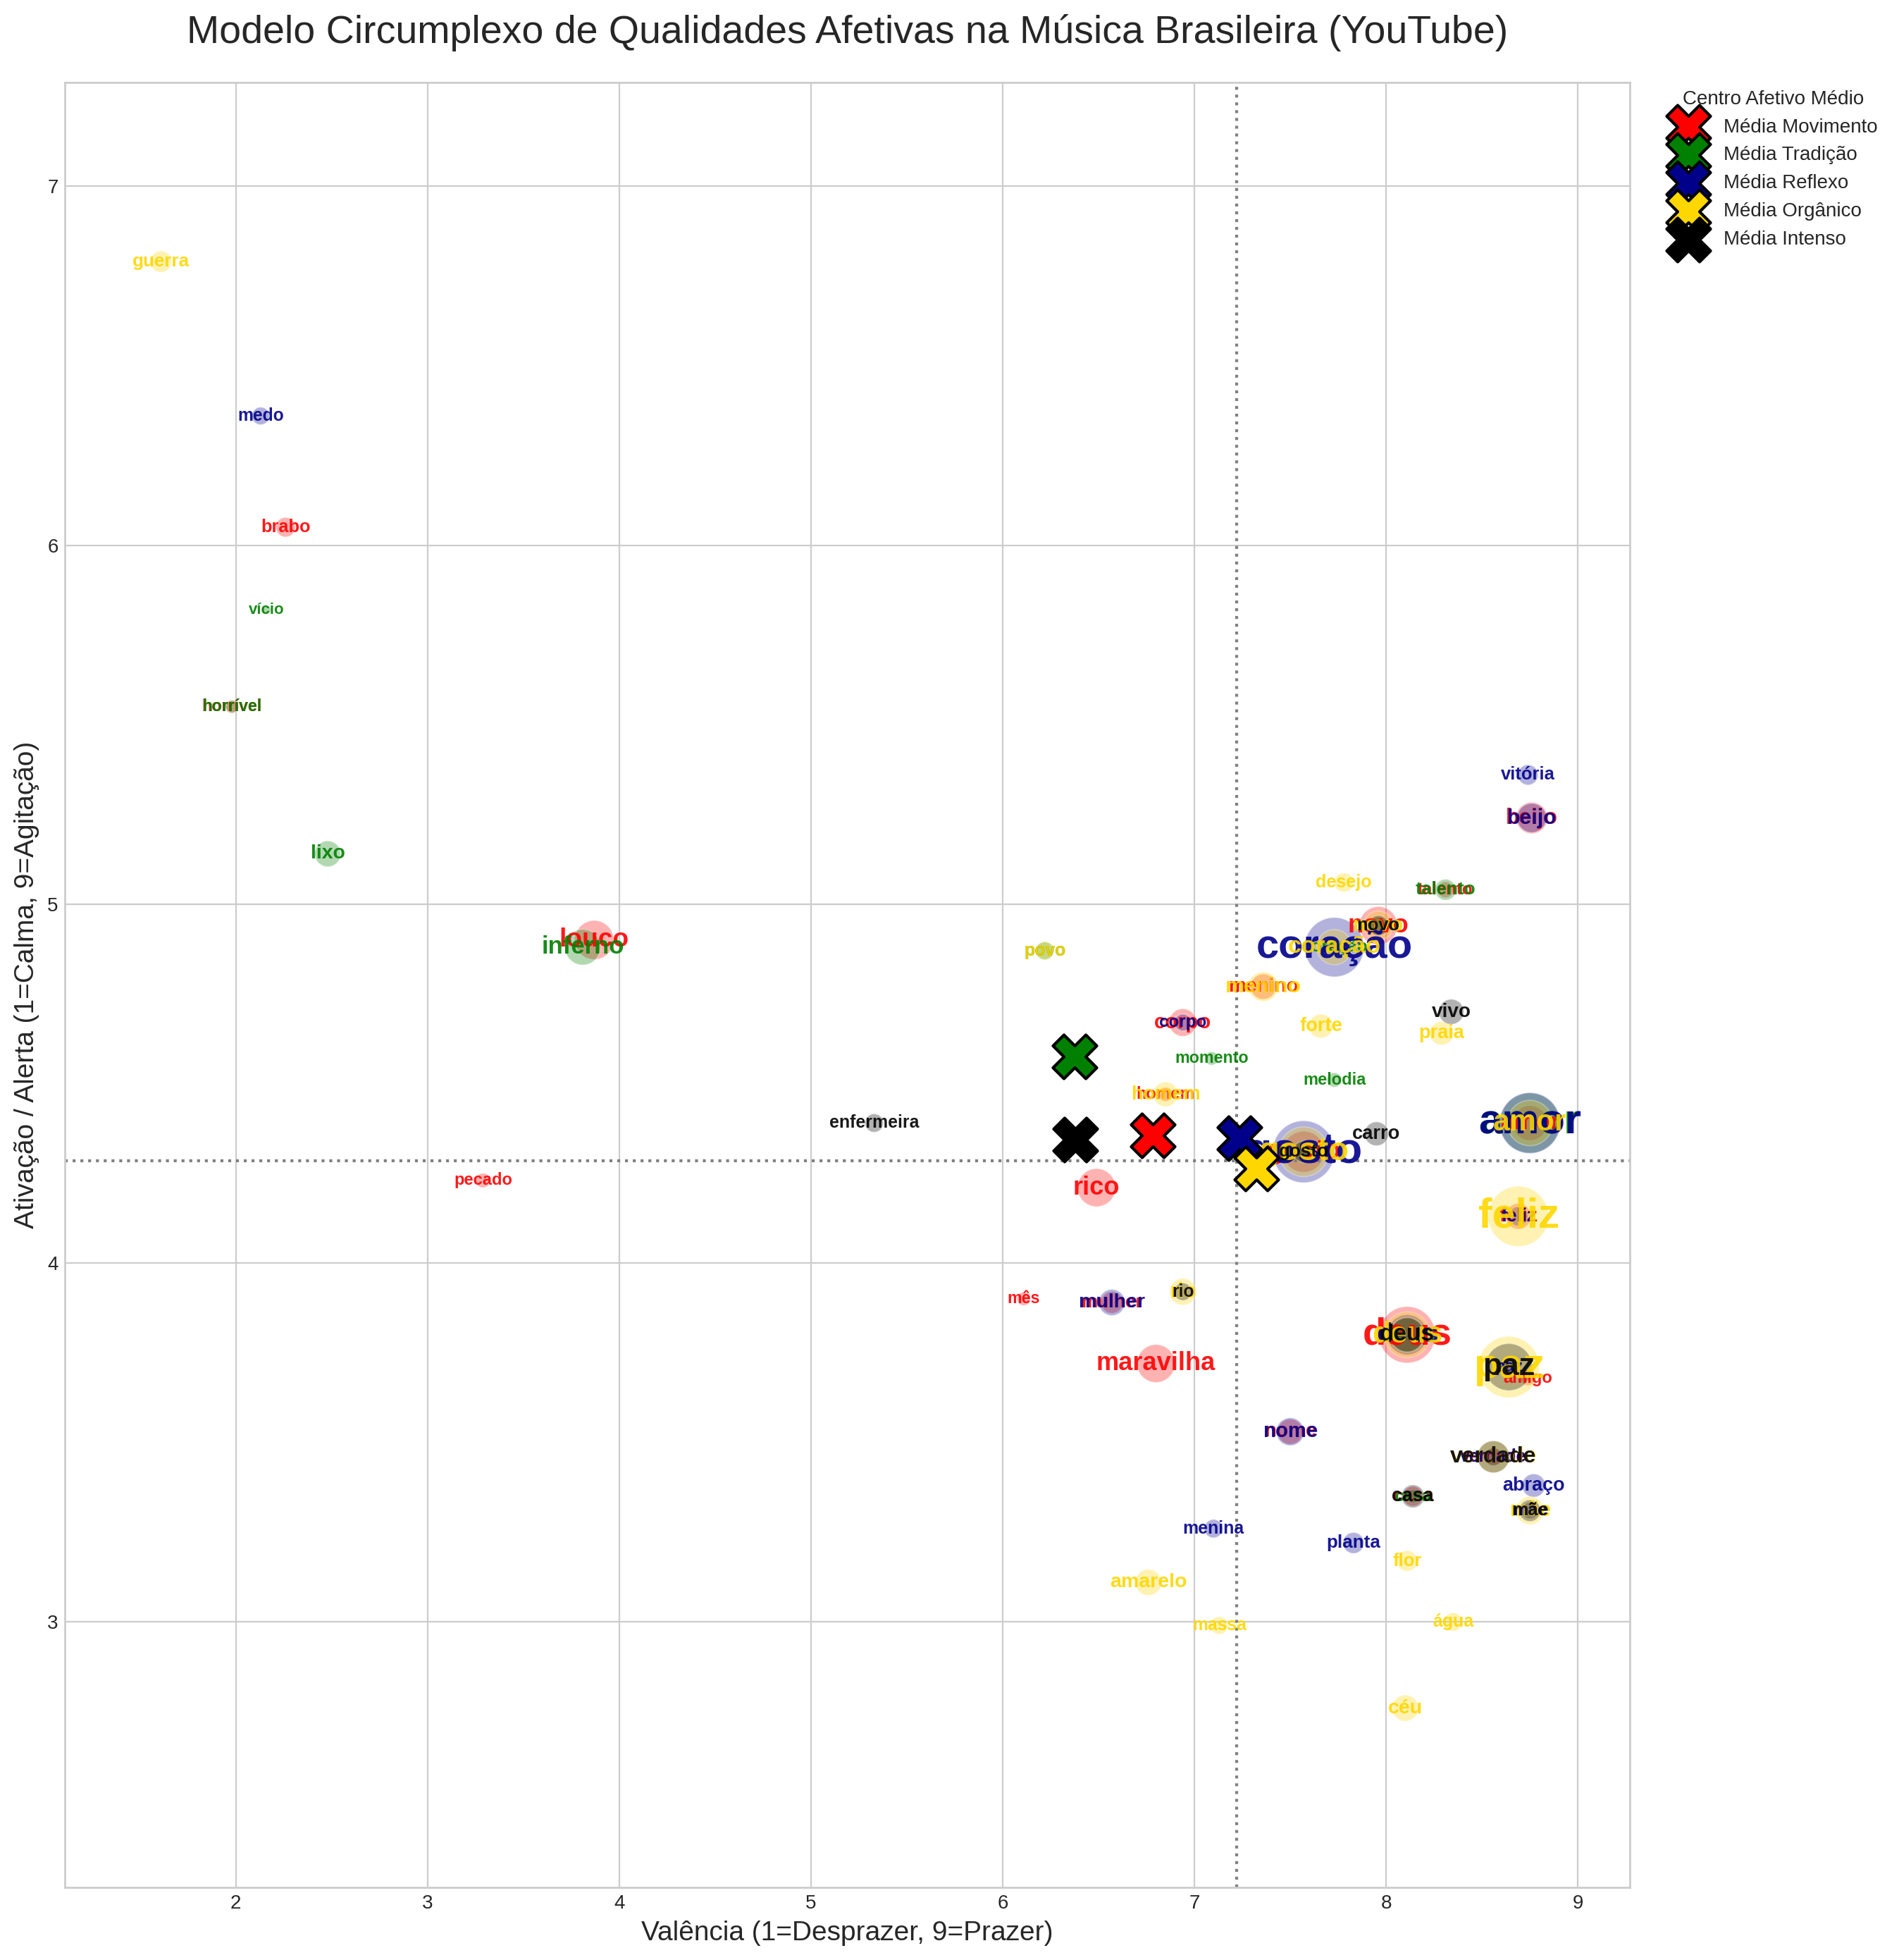

In [ ]:
# --- Gerando a visualiza√ß√£o final ---

print("\nGerando a visualiza√ß√£o final com tamanho de fonte din√¢mico...")
if df_plot_final.empty:
    print("Nenhum dado para plotar. Verifique seu l√©xico e suas contagens.")
else:
    # 1. Definir a paleta de cores personalizada
    cores_personalizadas = {
        'Movimento': 'red', 'Reflexo': 'darkblue', 'Tradi√ß√£o': 'green',
        'Intenso': 'black', 'Org√¢nico': 'gold'
    }

    # 2. Configurar o gr√°fico
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 14))

    # 3. Plotar as bolhas de fundo (opcional, mas visualmente agrad√°vel)
    # Vamos torn√°-las bem sutis para que o texto seja o foco principal.
    sns.scatterplot(
        data=df_plot_final, x='valencia', y='ativacao', hue='fator',
        palette=cores_personalizadas, size='frequencia', sizes=(20, 1000),
        alpha=0.3, ax=ax, legend=False # Legenda desativada
    )

    # 4. Adicionar o nome de cada palavra com TAMANHO DIN√ÇMICO
    # Normalizar a frequ√™ncia para um intervalo de tamanho de fonte (ex: 8 a 22)
    freq_min = df_plot_final['frequencia'].min()
    freq_max = df_plot_final['frequencia'].max()
    tamanho_min_fonte = 8
    tamanho_max_fonte = 22

    for index, row in df_plot_final.iterrows():
        # Mapeamento linear da frequ√™ncia para o tamanho da fonte
        tamanho_fonte = np.interp(row['frequencia'], [freq_min, freq_max], [tamanho_min_fonte, tamanho_max_fonte])

        ax.text(
            x=row['valencia'], y=row['ativacao'], s=row['palavra'],
            fontdict=dict(
                color=cores_personalizadas.get(row['fator']),
                size=tamanho_fonte, # Tamanho da fonte agora √© din√¢mico
                weight='bold', # Deixar em negrito para melhor leitura
                ha='center', # Centralizar o texto no ponto
                va='center'
            ),
            alpha=0.9
        )

    # 5. Plotar os "centros de gravidade" e criar a LEGENDA
    for fator_nome in df_perfil_afetivo['Fator_RITMO'].unique():
        perfil = df_perfil_afetivo[df_perfil_afetivo['Fator_RITMO'] == fator_nome]
        if not perfil.empty:
            cor_fator = cores_personalizadas.get(fator_nome, 'gray')
            ax.scatter(
                x=perfil['Valencia_Media'], y=perfil['Ativacao_Media'],
                marker='X', s=500,
                color=cor_fator,
                edgecolor='black',
                linewidth=1.5,
                zorder=10,
                # A m√°gica da legenda acontece aqui:
                label=f'M√©dia {fator_nome}'
            )

    # 6. Configura√ß√µes finais do gr√°fico
    ax.axhline(df_plot_final['ativacao'].mean(), color='gray', linestyle=':')
    ax.axvline(df_plot_final['valencia'].mean(), color='gray', linestyle=':')
    ax.set_xlabel('Val√™ncia (1=Desprazer, 9=Prazer)', fontsize=14)
    ax.set_ylabel('Ativa√ß√£o / Alerta (1=Calma, 9=Agita√ß√£o)', fontsize=14)
    ax.set_title('Modelo Circumplexo de Qualidades Afetivas na M√∫sica Brasileira (YouTube)', fontsize=20, pad=20)

    # Definir limites para dar um pouco de "respiro"
    ax.set_xlim(df_plot_final['valencia'].min() - 0.5, df_plot_final['valencia'].max() + 0.5)
    ax.set_ylim(df_plot_final['ativacao'].min() - 0.5, df_plot_final['ativacao'].max() + 0.5)

    # 7. Exibir a legenda na lateral direita
    ax.legend(title='Centro Afetivo M√©dio', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta o layout para garantir que a legenda n√£o seja cortada
    plt.show()

In [ ]:
try:
    df_plot_final
except NameError:
    print("ERRO: O DataFrame 'df_plot_final' n√£o foi encontrado.")
    print("Por favor, rode o c√≥digo que cruza os dados do l√©xico com a contagem de palavras primeiro.")
else:
    # 1. Selecionar as colunas de interesse
    # O DataFrame j√° tem tudo o que precisamos, ent√£o n√£o precisamos criar nada novo.

    # 2. Ordenar os dados para facilitar a leitura
    # Vamos ordenar primeiro pelo fator, e depois pela frequ√™ncia (da maior para a menor)
    df_tabela_final = df_plot_final.sort_values(
        by=['fator', 'frequencia'],
        ascending=[True, False]
    ).reset_index(drop=True) # Reseta o √≠ndice para ficar limpo (0, 1, 2...)

    # Renomear as colunas para a tabela final ficar mais clara
    df_tabela_final.rename(columns={
        'fator': 'Fator RITMO',
        'palavra': 'Palavra Afetiva',
        'frequencia': 'Frequ√™ncia',
        'valencia': 'Val√™ncia M√©dia (ANEW)',
        'ativacao': 'Ativa√ß√£o M√©dia (ANEW)'
    }, inplace=True)

    # 3. Exibir a tabela completa
    print("--- Tabela de Palavras Afetivas Mapeadas por Fator (usadas no gr√°fico) ---")

    # Ajustar as op√ß√µes de exibi√ß√£o do Pandas para mostrar todas as linhas
    pd.set_option('display.max_rows', None)

    display(df_tabela_final)

    # Resetar as op√ß√µes de exibi√ß√£o para o padr√£o depois de mostrar
    pd.reset_option('display.max_rows')

    # 4. Opcional: Salvar esta tabela em um arquivo CSV ou Excel
    nome_arquivo_tabela = 'tabela_palavras_grafico.csv'
    df_tabela_final.to_csv(nome_arquivo_tabela, index=False)
    print(f"\nTabela salva como '{nome_arquivo_tabela}'")

--- Tabela de Palavras Afetivas Mapeadas por Fator (usadas no gr√°fico) ---


Fator RITMO Palavra Afetiva  Frequ√™ncia  Val√™ncia M√©dia (ANEW)  \
0      Intenso             paz         184                   8.64   
1      Intenso            deus         112                   8.11   
2      Intenso         verdade         101                   8.56   
3      Intenso            vivo          74                   8.34   
4      Intenso           carro          70                   7.95   
5      Intenso            casa          67                   8.14   
6      Intenso             m√£e          63                   8.75   
7      Intenso           gosto          61                   7.57   
8      Intenso            novo          59                   7.96   
9      Intenso      enfermeira          54                   5.33   
10     Intenso             rio          52                   6.94   
11   Movimento            deus         251                   8.11   
12   Movimento           gosto         147                   7.57   
13   Movimento           louco         136                   3.87   
14   Movimento            novo         131                   7.96   
15   Movimento            rico         131                   6.49   
16   Movimento       maravilha         130                   6.80   
17   Movimento            amor         114                   8.75   
18   Movimento           beijo          99                   8.76   
19   Movimento           corpo          83                   6.94   
20   Movimento           feliz          76                   8.69   
21   Movimento          menino          75                   7.36   
22   Movimento            nome          74                   7.50   
23   Movimento          mulher          63                   6.57   
24   Movimento           brabo          57                   2.26   
25   Movimento            casa          57                   8.14   
26   Movimento         verdade          50                   8.56   
27   Movimento         talento          48                   8.31   
28   Movimento           amigo          46                   8.74   
29   Movimento          pecado          45                   3.29   
30   Movimento           homem          44                   6.85   
31   Movimento        horr√≠vel          43                   1.98   
32   Movimento             m√™s          43                   6.11   
33    Org√¢nico             paz         291                   8.64   
34    Org√¢nico           feliz         282                   8.69   
35    Org√¢nico           gosto         202                   7.57   
36    Org√¢nico            deus         176                   8.11   
37    Org√¢nico            amor         174                   8.75   
38    Org√¢nico         cora√ß√£o         117                   7.73   
39    Org√¢nico         verdade         102                   8.56   
40    Org√¢nico          menino          91                   7.36   
41    Org√¢nico            novo          90                   7.96   
42    Org√¢nico             m√£e          85                   8.75   
43    Org√¢nico             rio          80                   6.94   
44    Org√¢nico         amarelo          78                   6.76   
45    Org√¢nico             c√©u          78                   8.10   
46    Org√¢nico           homem          73                   6.85   
47    Org√¢nico           forte          70                   7.66   
48    Org√¢nico           praia          69                   8.29   
49    Org√¢nico          guerra          62                   1.61   
50    Org√¢nico            flor          60                   8.11   
51    Org√¢nico          desejo          56                   7.78   
52    Org√¢nico            √°gua          54                   8.35   
53    Org√¢nico            povo          53                   6.22   
54    Org√¢nico           massa          52                   7.13   
55     Reflexo           gosto         296                   7.57   
56     Reflexo            amor       


Tabela salva como 'tabela_palavras_grafico.csv'


__________________

In [ ]:
# @title Classificando Val√™ncia e Ativa√ß√£o com Zero-Shot

!pip install transformers torch sentencepiece -q

from transformers import pipeline

# Carregar o pipeline de Zero-Shot Classification
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 942.2 kB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Crie esta c√©lula logo ap√≥s carregar o seu 'classifier'

# R√≥tulos para a dimens√£o de VAL√äNCIA (de muito ruim a muito bom)
rotulos_valencia = [
    "extremamente negativo, horr√≠vel, odioso",
    "negativo, ruim, triste",
    "neutro, indiferente",
    "positivo, bom, feliz",
    "extremamente positivo, incr√≠vel, maravilhoso"
]

# R√≥tulos para a dimens√£o de ATIVA√á√ÉO (de muito calmo a muito agitado)
rotulos_ativacao = [
    "extremamente calmo, relaxante, sereno",
    "calmo, tranquilo",
    "moderado, normal",
    "agitado, energ√©tico, intenso",
    "extremamente agitado, euf√≥rico, fren√©tico"
]

# Mapeamento dos r√≥tulos para uma escala num√©rica (1 a 9) para o gr√°fico
# Chave: R√≥tulo de texto, Valor: Ponto na escala
mapa_valencia_para_numero = {
    "extremamente negativo, horr√≠vel, odioso": 0,
    "negativo, ruim, triste": 1,
    "neutro, indiferente": 2,
    "positivo, bom, feliz": 3,
    "extremamente positivo, incr√≠vel, maravilhoso": 4,
}

mapa_ativacao_para_numero = {
    "extremamente calmo, relaxante, sereno": 0,
    "calmo, tranquilo": 1,
    "moderado, normal": 2,
    "agitado, energ√©tico, intenso": 3,
    "extremamente agitado, euf√≥rico, fren√©tico": 4,
}

print("R√≥tulos e mapas de convers√£o definidos com sucesso.")

R√≥tulos e mapas de convers√£o definidos com sucesso.


In [ ]:
tqdm.pandas()

def classificar_afeto_zs_granular(texto):
    if not isinstance(texto, str) or len(texto.split()) < 2:
        return None, None
    try:
        # Classifica Val√™ncia
        resultado_val = classifier(texto, rotulos_valencia, multi_label=False)
        rotulo_val = resultado_val['labels'][0]
        numero_val = mapa_valencia_para_numero.get(rotulo_val) # Converte para n√∫mero

        # Classifica Ativa√ß√£o
        resultado_ati = classifier(texto, rotulos_ativacao, multi_label=False)
        rotulo_ati = resultado_ati['labels'][0]
        numero_ati = mapa_ativacao_para_numero.get(rotulo_ati) # Converte para n√∫mero

        return numero_val, numero_ati
    except Exception as e:
        # print(f"Erro ao processar texto: {texto} | Erro: {e}")
        return None, None

# --- TESTE EM UMA AMOSTRA PEQUENA PRIMEIRO ---
print("Iniciando teste de classifica√ß√£o em uma amostra de 100 coment√°rios...")
df_amostra = df_robusto.sample(100, random_state=42).copy() # .copy() evita warnings

# O '.progress_apply' vai mostrar uma barra de progresso, muito √∫til para processos longos
df_amostra[['valencia_zs', 'ativacao_zs']] = df_amostra['text'].progress_apply(
    lambda x: pd.Series(classificar_afeto_zs_granular(x))
)

print("\nTeste conclu√≠do. Verificando os resultados da amostra:")
display(df_amostra[['text', 'valencia_zs', 'ativacao_zs']].head())

Iniciando teste de classifica√ß√£o em uma amostra de 100 coment√°rios...


  0%|          | 0/100 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Teste conclu√≠do. Verificando os resultados da amostra:


text  valencia_zs  \
33553  Eu vi para aqui pq os meninos cantaram essa m√∫...          4.0   
9427                      Ele parece com o Paulo Gustavo          4.0   
199                                            Diamoüéâ‚ù§üòäüòÆ          NaN   
12447                    Nois vai descer pra BC kkkkkkkk          2.0   
39489  AS MELHORES BANDA DO BRASIL CIDADE NEGRA ,QUE ...          4.0   

       ativacao_zs  
33553          3.0  
9427           4.0  
199            NaN  
12447          3.0  
39489          3.0

In [ ]:
# @title Filtragem para selecionar s√≥ os coment√°rios que tem os termos alvo palavras-chave afetivas encontradas no data set (com mais algumas)

# 1. Definir a lista completa de palavras-chave
palavras_chave_afetivas = list(set([
    'amo', 'linda', 'top', 'gosto', 'charmosa', 'louco', 'dan√ßando', 'maravilha', 'chique',
    'amor', 'ruim', 'amei', 'inferno', 'perfeita', 'viciada', 'recorda√ß√µes', 'gostei',
    'pedrada', 'pancada', 'lixo', 'cora√ß√£o', 'dispara', 'vibe', 'penso', 'lembro',
    'maravilhosa', 'gra√ßa', 'paz', 'feliz', 'chore', 'foda', 'descanse', 'merda',
    'bons', 'delicia', 'grande', 'triste', 'tristeza', 'chato', 'chata', 'saudade',
    'melancolia', 'melanc√≥lico', 'desanimado', 'des√¢nimo', 'mon√≥tono', 'sozinho',
    'vazio', 'chorei', 'chorando', 'calma', 'calmo', 'relaxante', 'relaxar',
    'tranquilo', 'tranquilidade', 'sereno', 'serenidade', 'conforto', 'confort√°vel',
    'suave', 'leve', 'gostoso'
]))
print(f"Usando {len(palavras_chave_afetivas)} palavras-chave afetivas √∫nicas para a filtragem.")

# 2. Criar o padr√£o de busca e filtrar o DataFrame
padrao_regex = r'\b(' + '|'.join(palavras_chave_afetivas) + r')\b'
print("\nFiltrando o dataset para manter apenas coment√°rios relevantes...")

# A M√ÅGICA EST√Å AQUI: .copy() cria um DataFrame novo e independente
df_filtrado = df_robusto[df_robusto['text'].str.contains(padrao_regex, case=False, na=False)].copy()

print(f"Filtragem conclu√≠da. O novo dataset tem {len(df_filtrado)} coment√°rios.")

Usando 63 palavras-chave afetivas √∫nicas para a filtragem.

Filtrando o dataset para manter apenas coment√°rios relevantes...


/tmp/ipython-input-19-2829083701.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado = df_robusto[df_robusto['text'].str.contains(padrao_regex, case=False, na=False)].copy()


Filtragem conclu√≠da. O novo dataset tem 11080 coment√°rios.


In [ ]:
# @title Classifica√ß√£o com modelo de zero-shot classification

# Carregar o modelo
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli", device=0) # device=0 for√ßa o uso da GPU
print("Modelo carregado.")

# Definir r√≥tulos e mapas de convers√£o
rotulos_valencia = ["muito negativo", "negativo", "neutro", "positivo", "muito positivo"]
rotulos_ativacao = ["muito calmo", "calmo", "moderado", "agitado", "muito agitado"]
mapa_valencia_para_numero = {rotulo: i for i, rotulo in enumerate(rotulos_valencia)}
mapa_ativacao_para_numero = {rotulo: i for i, rotulo in enumerate(rotulos_ativacao)}

# 3. Definir a fun√ß√£o de classifica√ß√£o
def classificar_afeto_zs_likert(texto):
    if not isinstance(texto, str) or len(texto.split()) < 2: return None, None
    try:
        val = classifier(texto, rotulos_valencia, multi_label=False)
        ati = classifier(texto, rotulos_ativacao, multi_label=False)
        numero_val = mapa_valencia_para_numero.get(val['labels'][0])
        numero_ati = mapa_ativacao_para_numero.get(ati['labels'][0])
        return numero_val, numero_ati
    except Exception:
        return None, None

# 4. Aplicar a classifica√ß√£o (este √© o passo demorado)
print(f"\nIniciando a classifica√ß√£o dos {len(df_filtrado)} coment√°rios.")
resultados_classificacao = df_filtrado['text'].progress_apply(
    lambda x: pd.Series(classificar_afeto_zs_likert(x))
)
df_filtrado.loc[:, ['valencia_zs', 'ativacao_zs']] = resultados_classificacao.values

print("\nClassifica√ß√£o conclu√≠da!")
# Salvar este resultado para n√£o precisar rodar de novo!
df_filtrado.to_csv('comentarios_classificados_final.csv', index=False)
print("Resultados salvos em 'comentarios_classificados_final.csv'")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Modelo carregado.

Iniciando a classifica√ß√£o dos 11080 coment√°rios.


  0%|          | 0/11080 [00:00<?, ?it/s]


Classifica√ß√£o conclu√≠da!
Resultados salvos em 'comentarios_classificados_final.csv'


In [ ]:
import pandas as pd

# Carregar o seu dataset j√° classificado
caminho_csv_classificado = 'comentarios_classificados_final.csv'
df_com_nulos = pd.read_csv(caminho_csv_classificado)

print("--- Dados Antes da Limpeza Final ---")
print(f"Total de linhas: {len(df_com_nulos)}")
print("Contagem de nulos:")
print(df_com_nulos[['valencia_zs', 'ativacao_zs']].isnull().sum())

# A M√ÅGICA EST√Å AQUI: .dropna() remove as linhas com valores nulos
# subset=['valencia_zs', 'ativacao_zs'] -> diz para olhar apenas para estas colunas
df_classificado_limpo = df_com_nulos.dropna(subset=['valencia_zs', 'ativacao_zs']).copy()

print("\n--- Dados Ap√≥s a Limpeza Final ---")
print(f"Total de linhas restantes: {len(df_classificado_limpo)}")
print("Nova contagem de nulos:")
print(df_classificado_limpo[['valencia_zs', 'ativacao_zs']].isnull().sum())

--- Dados Antes da Limpeza Final ---
Total de linhas: 11080
Contagem de nulos:
valencia_zs    377
ativacao_zs    377
dtype: int64

--- Dados Ap√≥s a Limpeza Final ---
Total de linhas restantes: 10703
Nova contagem de nulos:
valencia_zs    0
ativacao_zs    0
dtype: int64


In [ ]:
# @title Preparar os dados para gr√°fico
from collections import Counter
import numpy as np

# Supondo que 'palavras_chave_afetivas' j√° foi definido

# Usar o DataFrame limpo
df_classificado_limpo['texto_limpo'] = df_classificado_limpo['text'].str.lower()

dados_para_plotar_final = []
for palavra in palavras_chave_afetivas:
    comentarios_com_palavra = df_classificado_limpo[
        df_classificado_limpo['texto_limpo'].str.contains(f"\\b{palavra}\\b", na=False)
    ]
    if len(comentarios_com_palavra) > 3:
        val_media = comentarios_com_palavra['valencia_zs'].mean()
        ati_media = comentarios_com_palavra['ativacao_zs'].mean()
        frequencia = len(comentarios_com_palavra)
        fator_dominante = comentarios_com_palavra['fator_ritmo'].mode()[0]
        dados_para_plotar_final.append({
            'fator': fator_dominante, 'palavra': palavra, 'frequencia': frequencia,
            'valencia': val_media, 'ativacao': ati_media
        })
df_plot_final = pd.DataFrame(dados_para_plotar_final)

df_perfil_afetivo_final = df_classificado_limpo.groupby('fator_ritmo')[['valencia_zs', 'ativacao_zs']].mean().reset_index()

print("\nDados prontos para o plot.")


Dados prontos para o plot.


In [ ]:
import pandas as pd

# ==============================================================================
# PASSO 1: VERIFICAR O DATAFRAME AP√ìS A CLASSIFICA√á√ÉO E LIMPEZA
# ==============================================================================
# Supondo que 'df_classificado_limpo' foi o nome que demos ao DataFrame final
# ap√≥s remover os valores nulos.

print("--- DIAGN√ìSTICO DO DATAFRAME CLASSIFICADO E LIMPO ('df_classificado_limpo') ---")

try:
    # Informa√ß√µes gerais: tipos de dados e contagem de nulos
    print("\n[INFO] Informa√ß√µes gerais do DataFrame:")
    df_classificado_limpo.info()

    # Estat√≠sticas descritivas das colunas de val√™ncia e ativa√ß√£o
    print("\n[STATS] Estat√≠sticas descritivas para as colunas de classifica√ß√£o:")
    # Isso nos mostrar√° a m√©dia, desvio padr√£o, m√≠nimo, m√°ximo, etc.
    # Se os valores de 'mean', 'min', 'max' estiverem fora da nossa escala (0-4), h√° um problema.
    display(df_classificado_limpo[['valencia_zs', 'ativacao_zs']].describe())

    # Ver a distribui√ß√£o de valores para cada categoria
    print("\n[DISTRIBUI√á√ÉO] Distribui√ß√£o dos valores classificados para VAL√äNCIA:")
    print(df_classificado_limpo['valencia_zs'].value_counts())

    print("\n[DISTRIBUI√á√ÉO] Distribui√ß√£o dos valores classificados para ATIVA√á√ÉO:")
    print(df_classificado_limpo['ativacao_zs'].value_counts())

except NameError:
    print("\nERRO: O DataFrame 'df_classificado_limpo' n√£o foi encontrado.")
    print("Certifique-se de que a etapa de remo√ß√£o de nulos foi executada.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")


# ==============================================================================
# PASSO 2: VERIFICAR O DATAFRAME PRONTO PARA O PLOT
# ==============================================================================
# Supondo que 'df_plot_final' foi o nome que demos ao DataFrame que alimenta o gr√°fico.

print("\n\n--- DIAGN√ìSTICO DO DATAFRAME PARA VISUALIZA√á√ÉO ('df_plot_final') ---")

try:
    print(f"\n[INFO] O DataFrame para o plot tem {len(df_plot_final)} linhas.")

    # Verificar se h√° valores nulos neste DataFrame final
    print("\n[NULOS] Contagem de valores nulos no DataFrame do plot:")
    print(df_plot_final.isnull().sum())

    # Exibir as primeiras e √∫ltimas linhas para ver a faixa de valores
    print("\n[AMOSTRA] Primeiras 5 linhas dos dados para o plot:")
    display(df_plot_final.head())
    print("\n[AMOSTRA] √öltimas 5 linhas dos dados para o plot:")
    display(df_plot_final.tail())

except NameError:
    print("\nERRO: O DataFrame 'df_plot_final' n√£o foi encontrado.")
    print("Certifique-se de que a etapa de prepara√ß√£o para o gr√°fico foi executada.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- DIAGN√ìSTICO DO DATAFRAME CLASSIFICADO E LIMPO ('df_classificado_limpo') ---

[INFO] Informa√ß√µes gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 10703 entries, 0 to 11079
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   author        10690 non-null  object 
 1   published_at  10703 non-null  object 
 2   text          10703 non-null  object 
 3   like_count    10703 non-null  int64  
 4   fator_ritmo   10703 non-null  object 
 5   texto_limpo   10703 non-null  object 
 6   valencia_zs   10703 non-null  float64
 7   ativacao_zs   10703 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 752.6+ KB

[STATS] Estat√≠sticas descritivas para as colunas de classifica√ß√£o:


valencia_zs   ativacao_zs
count  10703.000000  10703.000000
mean       2.780903      2.812669
std        0.943915      0.785628
min        0.000000      0.000000
25%        3.000000      3.000000
50%        3.000000      3.000000
75%        3.000000      3.000000
max        4.000000      4.000000


[DISTRIBUI√á√ÉO] Distribui√ß√£o dos valores classificados para VAL√äNCIA:
valencia_zs
3.0    7102
4.0    1609
1.0    1400
2.0     311
0.0     281
Name: count, dtype: int64

[DISTRIBUI√á√ÉO] Distribui√ß√£o dos valores classificados para ATIVA√á√ÉO:
ativacao_zs
3.0    8110
1.0     988
4.0     966
2.0     461
0.0     178
Name: count, dtype: int64


--- DIAGN√ìSTICO DO DATAFRAME PARA VISUALIZA√á√ÉO ('df_plot_final') ---

[INFO] O DataFrame para o plot tem 55 linhas.

[NULOS] Contagem de valores nulos no DataFrame do plot:
fator         0
palavra       0
frequencia    0
valencia      0
ativacao      0
dtype: int64

[AMOSTRA] Primeiras 5 linhas dos dados para o plot:


fator   palavra  frequencia  valencia  ativacao
0    Intenso   delicia         107  3.149533  2.897196
1    Intenso   saudade         211  2.530806  2.834123
2   Tradi√ß√£o   pancada          87  1.632184  3.080460
3   Org√¢nico       paz         508  2.834646  1.435039
4  Movimento  dan√ßando         105  2.542857  2.771429


[AMOSTRA] √öltimas 5 linhas dos dados para o plot:


fator  palavra  frequencia  valencia  ativacao
50   Reflexo    calmo           5  2.200000  1.400000
51  Tradi√ß√£o  viciada         154  2.889610  3.155844
52   Reflexo    vazio           6  1.666667  2.333333
53  Tradi√ß√£o  pedrada         125  1.744000  2.960000
54  Tradi√ß√£o     lixo         167  1.077844  3.017964


Gerando o gr√°fico final com jitter para melhor visualiza√ß√£o...


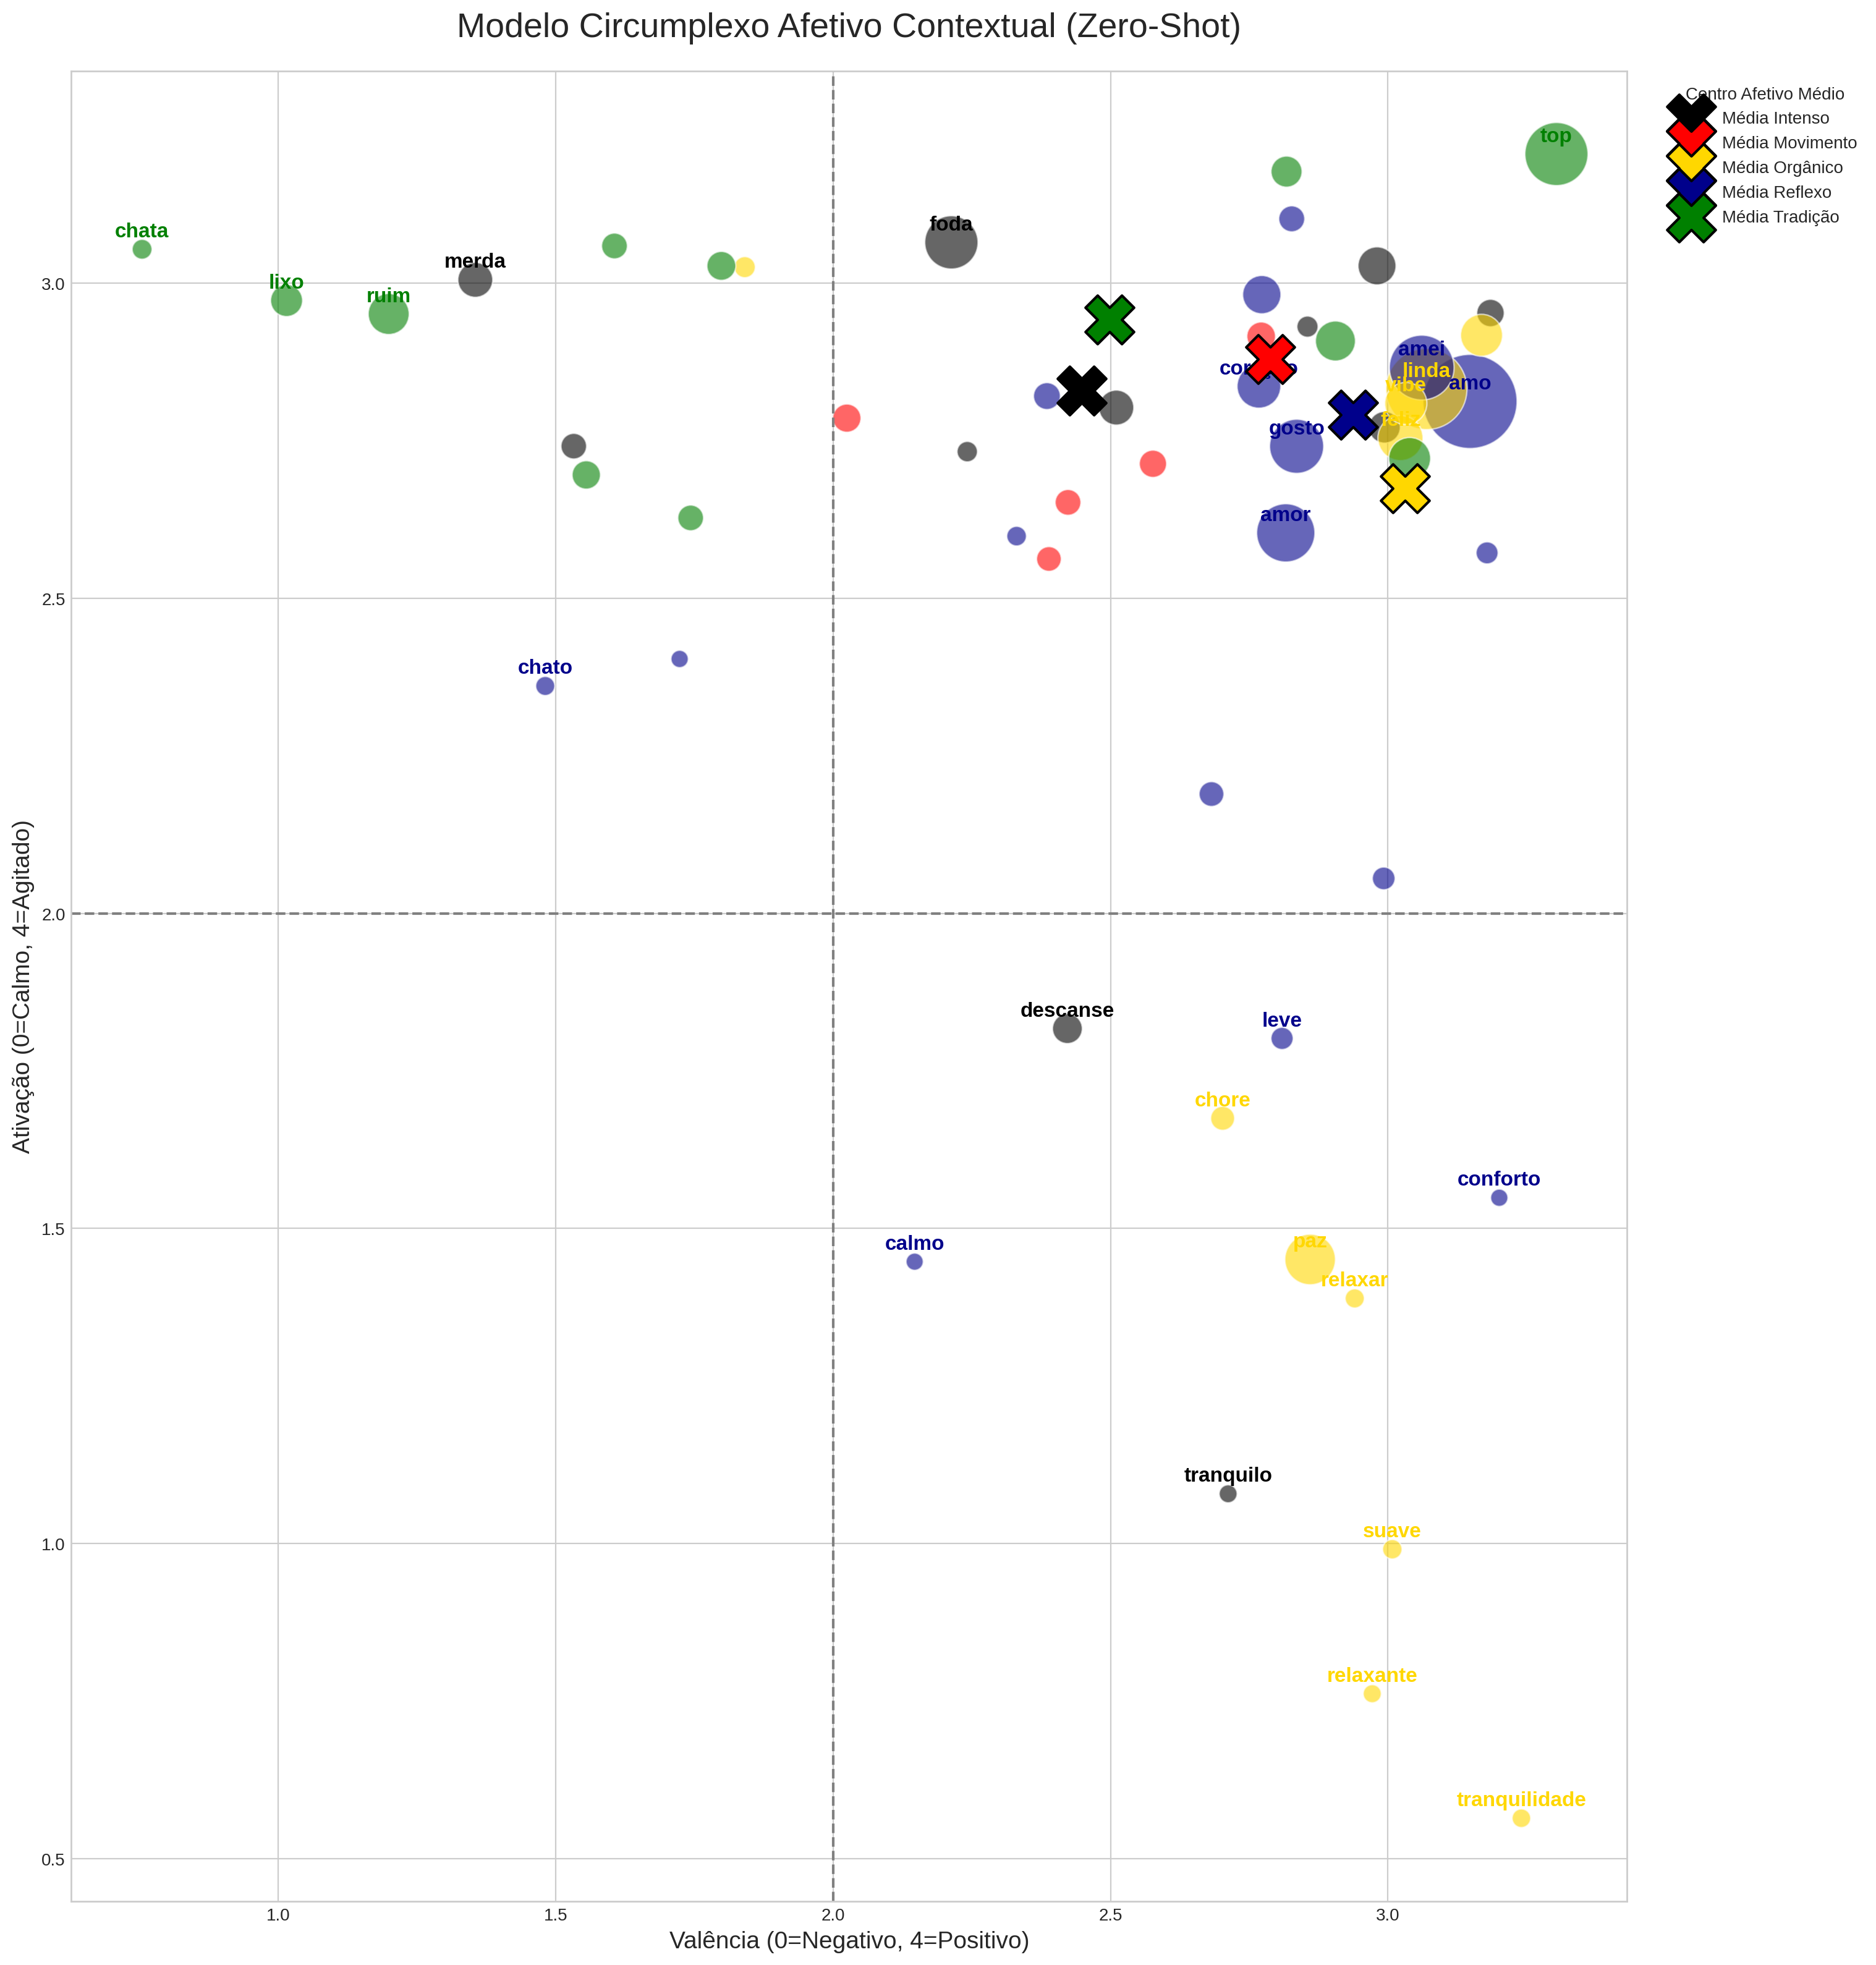

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supondo que 'df_plot_final' e 'df_perfil_afetivo_final' j√° foram criados.

# --- PASSO 1: ADICIONAR "JITTER" AO DATAFRAME DE PLOTAGEM ---
# Adicionar um pequeno valor aleat√≥rio para espalhar os pontos
jitter_strength = 0.08
df_plot_final['valencia_jitter'] = df_plot_final['valencia'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))
df_plot_final['ativacao_jitter'] = df_plot_final['ativacao'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))


# --- PASSO 2: VISUALIZA√á√ÉO COM JITTER E ANOTA√á√ÉO INTELIGENTE ---
print("\nGerando o gr√°fico final com jitter para melhor visualiza√ß√£o...")

cores_personalizadas = {
    'Movimento': 'red', 'Reflexo': 'darkblue', 'Tradi√ß√£o': 'green',
    'Intenso': 'black', 'Org√¢nico': 'gold'
}
fig, ax = plt.subplots(figsize=(18, 16))
plt.style.use('seaborn-v0_8-whitegrid')

# PLOTAR OS PONTOS COM JITTER
sns.scatterplot(
    data=df_plot_final,
    x='valencia_jitter', # Usar a coluna com jitter
    y='ativacao_jitter', # Usar a coluna com jitter
    hue='fator',
    palette=cores_personalizadas,
    size='frequencia',
    sizes=(100, 3000),
    alpha=0.6,
    ax=ax,
    legend=False
)

# ANOTAR DE FORMA INTELIGENTE (apenas as palavras mais importantes/extremas)
for index, row in df_plot_final.iterrows():
    # Condi√ß√£o para anotar: ser uma das mais frequentes OU estar nos extremos do gr√°fico
    if row['frequencia'] > df_plot_final['frequencia'].quantile(0.80) or \
       row['valencia'] < 1.5 or row['valencia'] > 3.5 or \
       row['ativacao'] < 2.0 or row['ativacao'] > 3.5:

        ax.text(
            x=row['valencia_jitter'], y=row['ativacao_jitter']+0.02, s=row['palavra'],
            fontdict=dict(
                color=cores_personalizadas.get(row['fator'], 'gray'),
                size=12, weight='bold', ha='center'
            )
        )

# Plotar os centros de gravidade
for index, row in df_perfil_afetivo_final.iterrows():
    fator_nome = row['fator_ritmo']
    ax.scatter(
        x=row['valencia_zs'], y=row['ativacao_zs'], marker='X', s=800,
        color=cores_personalizadas.get(fator_nome, 'gray'),
        edgecolor='black', linewidth=1.5, zorder=10,
        label=f'M√©dia {fator_nome}'
    )

# Configura√ß√µes finais
ax.axvline(x=2, color='gray', linestyle='--')
ax.axhline(y=2, color='gray', linestyle='--')
ax.set_xlabel('Val√™ncia (0=Negativo, 4=Positivo)', fontsize=14)
ax.set_ylabel('Ativa√ß√£o (0=Calmo, 4=Agitado)', fontsize=14)
ax.set_title('Modelo Circumplexo Afetivo Contextual (Zero-Shot)', fontsize=20, pad=20)
ax.legend(title='Centro Afetivo M√©dio', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
# @title Top10 pavras classificadas
try:
    top_10_por_fator = df_plot_final.groupby('fator').apply(
        lambda x: x.nlargest(10, 'frequencia')
    ).reset_index(drop=True)

    # Renomear as colunas para a tabela final ficar mais clara e profissional
    top_10_por_fator.rename(columns={
        'fator': 'Fator RITMO',
        'palavra': 'Palavra-Chave Afetiva',
        'frequencia': 'Frequ√™ncia de Ocorr√™ncia',
        'valencia': 'Val√™ncia M√©dia (ZS)',
        'ativacao': 'Ativa√ß√£o M√©dia (ZS)'
    }, inplace=True)

    # Arredondar os valores de val√™ncia e ativa√ß√£o para 2 casas decimais
    top_10_por_fator['Val√™ncia M√©dia (ZS)'] = top_10_por_fator['Val√™ncia M√©dia (ZS)'].round(2)
    top_10_por_fator['Ativa√ß√£o M√©dia (ZS)'] = top_10_por_fator['Ativa√ß√£o M√©dia (ZS)'].round(2)


    # Exibir a tabela final
    print("\nTabela com as 10 palavras mais frequentes por fator e suas coordenadas afetivas:")

    # Configurar Pandas para exibir a tabela completa
    pd.set_option('display.max_rows', 100)

    display(top_10_por_fator)

    pd.reset_option('display.max_rows')

    # Opcional: Salvar esta tabela crucial em um arquivo CSV
    top_10_por_fator.to_csv('tabela_top10_palavras_por_fator.csv', index=False)
    # print("\nTabela salva em 'tabela_top10_palavras_por_fator.csv'")

except NameError:
    print("\nERRO: O DataFrame 'df_plot_zs' n√£o foi encontrado.")
    print("Por favor, execute a etapa de prepara√ß√£o para o gr√°fico primeiro.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")


Tabela com as 10 palavras mais frequentes por fator e suas coordenadas afetivas:


/tmp/ipython-input-17-3598458246.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_por_fator = df_plot_final.groupby('fator').apply(


Fator RITMO Palavra-Chave Afetiva  Frequ√™ncia de Ocorr√™ncia  \
0      Intenso                  foda                       570   
1      Intenso                grande                       260   
2      Intenso               saudade                       211   
3      Intenso                 merda                       210   
4      Intenso                  bons                       161   
5      Intenso              descanse                       137   
6      Intenso               delicia                       107   
7      Intenso                triste                        85   
8      Intenso               sozinho                        39   
9      Intenso              tristeza                        32   
10   Movimento             maravilha                       122   
11   Movimento                 louco                       116   
12   Movimento              dan√ßando                       105   
13   Movimento              charmosa                        87   
14   Movimento                chique                        75   
15    Org√¢nico                 linda                      1402   
16    Org√¢nico                   paz                       508   
17    Org√¢nico                 feliz                       392   
18    Org√¢nico                  vibe                       334   
19    Org√¢nico           maravilhosa                       331   
20    Org√¢nico                 chore                        67   
21    Org√¢nico              chorando                        38   
22    Org√¢nico                 suave                        23   
23    Org√¢nico               relaxar                        21   
24    Org√¢nico         tranquilidade                        16   
25     Reflexo                   amo                      1908   
26     Reflexo                  amei                       872   
27     Reflexo                  amor                       693   
28     Reflexo                 gosto                       590   
29     Reflexo               cora√ß√£o                       364   
30     Reflexo                lembro                       265   
31     Reflexo                 gra√ßa                       100   
32     Reflexo               dispara                        89   
33     Reflexo                 penso                        76   
34     Reflexo                 calma                        54   
35    Tradi√ß√£o                   top                       824   
36    Tradi√ß√£o              perfeita                       330   
37    Tradi√ß√£o                  ruim                       313   
38    Tradi√ß√£o                gostei                       295   
39    Tradi√ß√£o                  lixo                       167   
40    Tradi√ß√£o               viciada                       154   
41    Tradi√ß√£o               pedrada                       125   
42    Tradi√ß√£o               inferno                       118   
43    Tradi√ß√£o               pancada                        87   
44    Tradi√ß√£o           recorda√ß√µes                        86   

    Val√™ncia M√©dia (ZS)  Ativa√ß√£o M√©dia (ZS)  valencia_jitter  ativacao_jitter  
0                  2.25                 3.11         2.213193         3.064725  
1                  2.93                 2.97         2.980410         3.027445  
2                  2.53                 2.83         2.510491         2.802551  
3                  1.28                 2.96         1.355041         3.005247  
4                  2.98                 2.70         2.993846         2.771279  
5                  2.39                 1.82         2.422304         1.816975  
6                  3.15                 2.90         3.184960         2.952578  
7                  1.52                 2.76         1.532515         2.741305  
8                  2.85                 2.90         2.855056         2.930998  
9                  2.19                 2.75         2.241775         2.732616  
10                 2.71         

___


Tentativa de pegar coment√°rios com baixa ativa√ß√£o (de prefer√™ncia baixa val√™ncia tamb√©m)

In [ ]:
# @title Baixa ativa√ß√£o

videos_baixa_ativacao = {
    'musica_dormir': '-RH-lM2BMcQ',    # V√≠deo: "Bons Sonhos üí§ M√∫sica Relaxante..."
    'musica_triste1': '4YWd1d4HoFE',    # V√≠deo: "Home - Tom Rosenthal [ Tradu√ß√£o/ legendado ]"
    'musica_triste2': 'xvJ6FxnJsRA'     # V√≠deo: Tom Rosenthal - Home // [tradu√ß√£o-legendado]
}

print("--- Coletando coment√°rios de contextos de Baixa Ativa√ß√£o ---")
lista_dfs_baixa_ativacao = []

# Agora este loop vai funcionar perfeitamente
for contexto, video_id in videos_baixa_ativacao.items():
    print(f"\nColetando para o contexto: '{contexto}' (V√≠deo ID: {video_id})")

    # Chama a fun√ß√£o de coleta para este v√≠deo
    df_contexto = coletar_comentarios(video_id, limit=5000)

    # Adiciona os coment√°rios coletados √† lista do fator
    if not df_contexto.empty:
        df_contexto['contexto'] = contexto # Identifica a origem do coment√°rio
        lista_dfs_baixa_ativacao.append(df_contexto)
        print(f"  -> Coletados {len(df_contexto)} coment√°rios.")
    else:
        print(f"  -> Nenhum coment√°rio coletado ou ocorreu um erro para o v√≠deo {video_id}.")

# Verificar se coletamos algum coment√°rio
if lista_dfs_baixa_ativacao:
    # Juntar todos os DataFrames de coment√°rios em um s√≥
    df_baixa_ativacao = pd.concat(lista_dfs_baixa_ativacao, ignore_index=True)
    print(f"\nColeta conclu√≠da. Total de {len(df_baixa_ativacao)} coment√°rios.")
else:
    print("\nColeta conclu√≠da. Nenhum coment√°rio foi coletado.")
    # Criar um DataFrame vazio para evitar erros nos pr√≥ximos passos
    df_baixa_ativacao = pd.DataFrame(columns=['text', 'contexto'])

--- Coletando coment√°rios de contextos de Baixa Ativa√ß√£o ---

Coletando para o contexto: 'musica_dormir' (V√≠deo ID: -RH-lM2BMcQ)
  -> Coletados 5000 coment√°rios.

Coletando para o contexto: 'musica_triste1' (V√≠deo ID: 4YWd1d4HoFE)
  -> Coletados 965 coment√°rios.

Coletando para o contexto: 'musica_triste2' (V√≠deo ID: xvJ6FxnJsRA)
  -> Coletados 985 coment√°rios.

Coleta conclu√≠da. Total de 6950 coment√°rios.


In [ ]:
def limpar_texto(texto):
    if not isinstance(texto, str):
        return ""
    # Remove URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    # Remove men√ß√µes e hashtags
    texto = re.sub(r'\@\w+|\#\w+', '', texto)
    # Converte para min√∫sculas
    texto = texto.lower()
    # Remove pontua√ß√£o
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    # Remove n√∫meros (opcional, mas recomendado)
    texto = re.sub(r'\d+', '', texto)
    # Remove espa√ßos em branco extras
    texto = " ".join(texto.split())
    return texto


# --- PASSO 2: PREPARAR A LISTA COMPLETA DE STOPWORDS ---
# Vamos usar a mesma lista abrangente que criamos para o estudo principal.
print("Preparando a lista de stopwords...")
try:
    portuguese_stops = set(stopwords.words('portuguese'))
except LookupError:
    nltk.download('stopwords')
    portuguese_stops = set(stopwords.words('portuguese'))

# Palavras gen√©ricas para ignorar
palavras_extras_gerais = {
    'm√∫sica', 'som', 'letra', 'clipe', 'video', 'gente', 't√°', 'n√©', 'faz', 'ver', 'sempre',
    'ainda', 'tudo', 'coisa', 'dia', 'dms', 'aqui', 'pra', 'vou', 'vai', 'ser', 'ter',
    'quer', 'mim', 'bem', 'agora', 't√£o', 's√≥', 'vc', 'mt', 'td', 'essa', 'esse',
    'obrigado', 'obrigada', 'deus', 'noite', 'boa', 'todos', 'q', 'vida', 'bom',
    'musica', 'paz', 'amo', 'nunca', 'jesus', 'sei', 'sono', 'ouvindo', 'algu√©m',
    'consigo', 'anos', 'cora√ß√£o', 'sinto', 'melhor', 'amor', 'ouvir', 'pessoas',
    'v√≠deo', 'coment√°rios'
}

# Palavras contextuais dos v√≠deos (tanto do estudo principal quanto deste)
stopwords_contexto = {
    # Estudo principal
    'jo√£o', 'gomes', 'tuto', 'glenner', 'barbie', 'nilo', 'paiva', 'marques', 'fuimlk', 'mlk',
    'brenno', 'matheus', 'descer', 'bc', 'simone', 'mendes', 'saudade', 'proibida', 'j√£o',
    'anavitoria', 'anavit√≥ria', 'vitor', 'kley', 'pupila', 'lagum', 'iza', 'cidade', 'negra',
    'girassol', 'natiruts', 'torture', 'squad', 'fallen', 'ones', 'matanza', 'mal', 'raimundos',
    'oco', 'shaman', 'carry', 'idiota', 'devo', 'explica√ß√µes', 'deve', 'deixou', 'tubar√µes', 'mar',
    'saber', 'guina','‚ù§',
    # Estudo complementar (adicionar palavras dos novos v√≠deos se necess√°rio)
    'dormir', 'relaxar', 'estudar', 'tranquilo', 'calma', 'home', 'rosenthal'
}

# Juntar todas as stopwords
portuguese_stops.update(palavras_extras_gerais)
portuguese_stops.update(stopwords_contexto)
print("Lista de stopwords pronta.")


# --- PASSO 3: APLICAR A LIMPEZA NO DATAFRAME 'df_baixa_ativacao' ---
print("\nIniciando a limpeza dos novos coment√°rios...")

# Garantir que n√£o h√° textos nulos
df_baixa_ativacao.dropna(subset=['text'], inplace=True)

# 1. Aplicar a limpeza b√°sica para criar 'texto_limpo'
df_baixa_ativacao['texto_limpo'] = df_baixa_ativacao['text'].apply(limpar_texto)

# 2. Criar a coluna 'texto_processado' sem as stopwords
def remover_stopwords(texto):
    palavras_filtradas = [palavra for palavra in texto.split() if palavra not in portuguese_stops]
    return " ".join(palavras_filtradas)

df_baixa_ativacao['texto_processado'] = df_baixa_ativacao['texto_limpo'].apply(remover_stopwords)

print("Limpeza conclu√≠da.")

# --- PASSO 4: VERIFICAR O RESULTADO ---
print("\nAmostra dos dados ap√≥s a limpeza:")
display(df_baixa_ativacao[['text', 'texto_limpo', 'texto_processado']].head())

# Salvar o DataFrame limpo para uso futuro
#df_baixa_ativacao.to_csv('comentarios_baixa_ativacao_limpos.csv', index=False)
#print("\nDataFrame limpo salvo como 'comentarios_baixa_ativacao_limpos.csv'")

Preparando a lista de stopwords...
Lista de stopwords pronta.

Iniciando a limpeza dos novos coment√°rios...
Limpeza conclu√≠da.

Amostra dos dados ap√≥s a limpeza:


text  \
0        Me lembra meu sonho de Deus üòÇüòÇüòÇüòÇüòÇüòÇüòÇ‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§üòä   
1                                    Algu√©m em 1990?   
2                                     üôè Gratid√£o ü§ó‚ù§Ô∏è   
3                 Assim seja obrigado Esp√≠rito Santo   
4  Eu amo pq essa m√∫sica √© a unica fora a deus na...   

                                         texto_limpo  \
0        me lembra meu sonho de deus üòÇüòÇüòÇüòÇüòÇüòÇüòÇ‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§üòä   
1                                          algu√©m em   
2                                     üôè gratid√£o ü§ó‚ù§Ô∏è   
3                 assim seja obrigado esp√≠rito santo   
4  eu amo pq essa m√∫sica √© a unica fora a deus na...   

                                    texto_processado  
0                       lembra sonho üòÇüòÇüòÇüòÇüòÇüòÇüòÇ‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§‚ù§üòä  
1                                                     
2                                     üôè gratid√£o ü§ó‚ù§Ô∏è  
3                               assim esp√≠rito santo  
4  pq unica acalmar crises nao dormi oro aben√ßoe ...

In [ ]:
from collections import Counter

# ==============================================================================
# PR√â-REQUISITO:
# O DataFrame 'df_baixa_ativacao' j√° deve existir e conter a coluna 'texto_processado',
# que √© a vers√£o do texto limpa e sem stopwords.
# ==============================================================================

print("--- Verificando as 30 palavras mais frequentes no corpus de Baixa Ativa√ß√£o ---")

try:
    # 1. Juntar todo o texto processado em uma √∫nica "text√£o"
    # Usamos .dropna() para garantir que n√£o haja valores nulos que possam causar erro.
    textao_baixa_ativacao = " ".join(df_baixa_ativacao['texto_processado'].dropna())

    # 2. Separar o text√£o em uma lista de palavras
    # N√£o precisamos mais remover stopwords aqui, pois j√° fizemos isso.
    lista_de_palavras_ba = textao_baixa_ativacao.split()

    # 3. Contar a frequ√™ncia das palavras
    contagem_palavras_ba = Counter(lista_de_palavras_ba)

    # 4. Exibir as 30 palavras mais comuns
    numero_de_palavras_para_mostrar = 200
    palavras_mais_comuns = contagem_palavras_ba.most_common(numero_de_palavras_para_mostrar)

    print(f"\nAs {numero_de_palavras_para_mostrar} palavras mais comuns s√£o:")
    # Imprimir em um formato mais leg√≠vel
    for palavra, contagem in palavras_mais_comuns:
        print(f"- {palavra}: {contagem} vezes")

except NameError:
    print("\nERRO: O DataFrame 'df_baixa_ativacao' n√£o foi encontrado.")
    print("Por favor, execute a etapa de coleta e limpeza primeiro.")
except KeyError:
    print("\nERRO: A coluna 'texto_processado' n√£o foi encontrada no DataFrame.")
    print("Certifique-se de que o c√≥digo de limpeza foi executado com sucesso.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- Verificando as 30 palavras mais frequentes no corpus de Baixa Ativa√ß√£o ---

As 200 palavras mais comuns s√£o:
- aben√ßoe: 280 vezes
- casa: 242 vezes
- ‚ù§: 238 vezes
- dormi: 204 vezes
- dias: 169 vezes
- fazer: 167 vezes
- quero: 165 vezes
- ansiedade: 165 vezes
- pessoa: 164 vezes
- nada: 161 vezes
- n: 158 vezes
- cada: 152 vezes
- todo: 152 vezes
- assim: 150 vezes
- t√¥: 150 vezes
- lembra: 149 vezes
- coisas: 149 vezes
- tempo: 146 vezes
- hoje: 145 vezes
- pq: 144 vezes
- ama: 144 vezes
- amei: 141 vezes
- m√∫sicas: 141 vezes
- medo: 141 vezes
- lugar: 138 vezes
- linda: 128 vezes
- relaxante: 127 vezes
- toda: 127 vezes
- feliz: 126 vezes
- porque: 126 vezes
- nome: 125 vezes
- pois: 125 vezes
- queria: 122 vezes
- m√£e: 122 vezes
- vezes: 121 vezes
- tanto: 121 vezes
- mundo: 120 vezes
- am√©m: 120 vezes
- durmo: 119 vezes
- gratid√£o: 117 vezes
- momento: 117 vezes
- you: 117 vezes
- senhor: 115 vezes
- nao: 114 vezes
- todas: 113 vezes
- i: 112 vezes
- escuto: 112 vez

In [ ]:
# Carregar o dataset do estudo principal (use a vers√£o balanceada, se tiver)
df_principal = pd.read_csv('comentarios_youtube_balanceado.csv')
# Se n√£o tiver o balanceado, use o 'comentarios_youtube_robusto.csv'

# Carregar o dataset do estudo complementar (o que acabamos de coletar)
df_complementar = pd.read_csv('comentarios_baixa_ativacao_limpos.csv')
# Renomear a coluna 'contexto' para 'fator_ritmo' para consist√™ncia
df_complementar.rename(columns={'contexto': 'fator_ritmo'}, inplace=True)


# Combinar os dois DataFrames em um √∫nico dataset final
df_combinado = pd.concat([df_principal, df_complementar], ignore_index=True)

print("--- Datasets Combinados ---")
print(f"Total de coment√°rios para an√°lise: {len(df_combinado)}")
print("\nDistribui√ß√£o final por fator/contexto:")
print(df_combinado['fator_ritmo'].value_counts())


# --- PASSO 2 (CORRIGIDO): Filtrar o Dataset Combinado com a Lista Completa ---

# Lista de palavras-chave originais, selecionadas dos fatores RITMO
palavras_chave_originais = [
    'amo', 'linda', 'top', 'gosto', 'charmosa', 'louco', 'dan√ßando', 'maravilha', 'chique',
    'amor', 'ruim', 'amei', 'inferno', 'perfeita', 'viciada', 'recorda√ß√µes', 'gostei',
    'pedrada', 'pancada', 'lixo', 'cora√ß√£o', 'dispara', 'vibe', 'penso', 'lembro',
    'maravilhosa', 'gra√ßa', 'feliz', 'chore', 'foda', 'descanse', 'merda',
    'bons', 'delicia', 'grande'
]

# Novas palavras que identificamos para os quadrantes de baixa ativa√ß√£o
palavras_baixa_ativacao = [
    # Positivas e Calmas
    'paz', 'relaxante', 'gratid√£o', 'acalma', 'acalmar', 'tranquilo', 'sonhos',
    'dormi', 'durmo', 'dormindo', 'dorme', 'dormiu', 'sono', 'melodia',
    'aben√ßoe', 'conforto', 'lindo', 'suave', 'leve', 'gostoso', 'sereno',
    'serenidade', 'tranquilidade',
    # Negativas e Calmas/Complexas
    'triste', 'tristeza', 'ansiedade', 'medo', 'chorar', 'chorando', 'dif√≠cil',
    'dor', 'ins√¥nia', 'problemas', 'lembrar', 'pensamentos', 'saudade',
    'melancolia', 'melanc√≥lico', 'desanimado', 'des√¢nimo', 'mon√≥tono',
    'sozinho', 'vazio', 'chorei'
]

# Combinar todas as listas em uma √∫nica lista final e remover duplicatas
palavras_chave_finais = list(set(palavras_chave_originais + palavras_baixa_ativacao))

print(f"Lista final e enriquecida cont√©m {len(palavras_chave_finais)} palavras-chave √∫nicas para a filtragem.")
print("Exemplo de algumas palavras:", sorted(palavras_chave_finais)[:30]) # Mostra as 30 primeiras em ordem alfab√©tica


if 'texto_limpo' not in df_combinado.columns:
    df_combinado.dropna(subset=['text'], inplace=True)
    # Use a sua fun√ß√£o de limpeza aqui. Exemplo:
    # df_combinado['texto_limpo'] = df_combinado['text'].apply(limpar_texto_avancado)
    df_combinado['texto_limpo'] = df_combinado['text'].str.lower()


# Criar o padr√£o de busca Regex com a lista final e enriquecida
padrao_regex = r'\b(' + '|'.join(palavras_chave_finais) + r')\b'

print(f"\nFiltrando o dataset com a lista de palavras ENRIQUECIDA...")
# .str.contains() verifica se o padr√£o regex existe em cada coment√°rio
df_filtrado_final = df_combinado[df_combinado['texto_limpo'].str.contains(padrao_regex, case=False, na=False)].copy()

print(f"Dataset final filtrado cont√©m {len(df_filtrado_final)} coment√°rios relevantes.")

--- Datasets Combinados ---
Total de coment√°rios para an√°lise: 56950

Distribui√ß√£o final por fator/contexto:
fator_ritmo
Movimento         10000
Tradi√ß√£o          10000
Reflexo           10000
Org√¢nico          10000
Intenso           10000
musica_dormir      5000
musica_triste2      985
musica_triste1      965
Name: count, dtype: int64
Lista final e enriquecida cont√©m 79 palavras-chave √∫nicas para a filtragem.
Exemplo de algumas palavras: ['aben√ßoe', 'acalma', 'acalmar', 'amei', 'amo', 'amor', 'ansiedade', 'bons', 'charmosa', 'chique', 'chorando', 'chorar', 'chore', 'chorei', 'conforto', 'cora√ß√£o', 'dan√ßando', 'delicia', 'desanimado', 'descanse', 'des√¢nimo', 'dif√≠cil', 'dispara', 'dor', 'dorme', 'dormi', 'dormindo', 'dormiu', 'durmo', 'feliz']

Filtrando o dataset com a lista de palavras ENRIQUECIDA...


/tmp/ipython-input-36-2274211369.py:64: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado_final = df_combinado[df_combinado['texto_limpo'].str.contains(padrao_regex, case=False, na=False)].copy()


Dataset final filtrado cont√©m 14732 coment√°rios relevantes.


In [ ]:
print(f"\nIniciando a classifica√ß√£o final dos {len(df_filtrado_final)} coment√°rios...")

resultados_classificacao = df_filtrado_final['text'].progress_apply(
    lambda x: pd.Series(classificar_afeto_zs_likert(x))
)
df_filtrado_final.loc[:, ['valencia_zs', 'ativacao_zs']] = resultados_classificacao.values

# Salvar o resultado mais importante da sua pesquisa!
df_filtrado_final.to_csv('dataset_final_classificado.csv', index=False)
print("\nClassifica√ß√£o final conclu√≠da e salva!")


Iniciando a classifica√ß√£o final dos 14732 coment√°rios...


  0%|          | 0/14732 [00:00<?, ?it/s]


Classifica√ß√£o final conclu√≠da e salva!


In [ ]:
# @title Carregar o dataset final e classificado
caminho_csv_final = 'dataset_final_classificado.csv'
try:
    df_final = pd.read_csv(caminho_csv_final)
    # Remover qualquer linha que possa ter falhado na classifica√ß√£o
    df_final.dropna(subset=['valencia_zs', 'ativacao_zs'], inplace=True)
    print(f"Dataset final classificado carregado com sucesso. Cont√©m {len(df_final)} coment√°rios v√°lidos.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{caminho_csv_final}' n√£o encontrado. A etapa de classifica√ß√£o precisa ser conclu√≠da primeiro.")

Dataset final classificado carregado com sucesso. Cont√©m 14282 coment√°rios v√°lidos.


In [ ]:
# @title Preparar dados

# Criar a coluna de texto limpo para a busca
if 'texto_limpo' not in df_final.columns:
    df_final['texto_limpo'] = df_final['text'].str.lower() # Adapte com sua fun√ß√£o de limpeza se necess√°rio

print("\nCalculando as coordenadas m√©dias para cada palavra-chave...")
dados_para_plotar = []
limite_minimo_frequencia = 5 # Manter um limite m√≠nimo para robustez estat√≠stica

for palavra in palavras_chave_finais:
    comentarios_com_palavra = df_final[df_final['texto_limpo'].str.contains(f"\\b{palavra}\\b", na=False)]

    if len(comentarios_com_palavra) > limite_minimo_frequencia:
        val_media_zs = comentarios_com_palavra['valencia_zs'].mean()
        ati_media_zs = comentarios_com_palavra['ativacao_zs'].mean()
        frequencia = len(comentarios_com_palavra)
        fator_dominante = comentarios_com_palavra['fator_ritmo'].mode()[0]

        dados_para_plotar.append({
            'fator': fator_dominante, 'palavra': palavra, 'frequencia': frequencia,
            'valencia': val_media_zs, 'ativacao': ati_media_zs
        })

df_plot_final = pd.DataFrame(dados_para_plotar)

# Calcular os centros de gravidade dos fatores
df_perfil_afetivo_final = df_final.groupby('fator_ritmo')[['valencia_zs', 'ativacao_zs']].mean().reset_index()

print("Dados prontos para o plot.")


Calculando as coordenadas m√©dias para cada palavra-chave...
Dados prontos para o plot.


In [ ]:
# @title Tabela com o Top 10

print("\n--- Tabela com as 10 Palavras Mais Frequentes por Fator e Suas Coordenadas Afetivas ---")

top_10_por_fator = df_plot_final.groupby('fator').apply(
    lambda x: x.nlargest(10, 'frequencia')
).reset_index(drop=True)

# Arredondar e renomear para a apresenta√ß√£o
top_10_por_fator['valencia'] = top_10_por_fator['valencia'].round(2)
top_10_por_fator['ativacao'] = top_10_por_fator['ativacao'].round(2)
top_10_por_fator.rename(columns={
    'fator': 'Fator/Contexto', 'palavra': 'Palavra-Chave', 'frequencia': 'Frequ√™ncia',
    'valencia': 'Val√™ncia M√©dia (0-4)', 'ativacao': 'Ativa√ß√£o M√©dia (0-4)'
}, inplace=True)

pd.set_option('display.max_rows', 100)
display(top_10_por_fator)
pd.reset_option('display.max_rows')


--- Tabela com as 10 Palavras Mais Frequentes por Fator e Suas Coordenadas Afetivas ---


/tmp/ipython-input-40-1941242610.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_por_fator = df_plot_final.groupby('fator').apply(


Fator/Contexto Palavra-Chave  Frequ√™ncia  Val√™ncia M√©dia (0-4)  \
0          Intenso          foda         544                  2.27   
1          Intenso        grande         311                  2.91   
2          Intenso       saudade         237                  2.50   
3          Intenso          bons         232                  3.01   
4          Intenso         merda         214                  1.26   
5          Intenso      descanse         152                  2.41   
6          Intenso       delicia         109                  3.15   
7        Movimento     maravilha         133                  2.77   
8        Movimento         louco         116                  2.08   
9        Movimento      dan√ßando         105                  2.57   
10       Movimento      charmosa          86                  2.42   
11       Movimento        chique          74                  2.35   
12        Org√¢nico         linda        1506                  3.03   
13        Org√¢nico         feliz         508                  2.97   
14        Org√¢nico          vibe         437                  3.06   
15        Org√¢nico   maravilhosa         368                  3.15   
16        Org√¢nico         chore          70                  2.73   
17         Reflexo           amo        2166                  3.09   
18         Reflexo          amei         982                  3.04   
19         Reflexo          amor         829                  2.79   
20         Reflexo         gosto         631                  2.84   
21         Reflexo       cora√ß√£o         535                  2.83   
22         Reflexo         lindo         462                  3.14   
23         Reflexo        lembro         317                  2.80   
24         Reflexo       lembrar         208                  2.87   
25         Reflexo         gra√ßa         112                  2.38   
26         Reflexo         penso         100                  2.59   
27        Tradi√ß√£o           top         835                  3.35   
28        Tradi√ß√£o      perfeita         362                  3.08   
29        Tradi√ß√£o          ruim         351                  1.35   
30        Tradi√ß√£o        gostei         334                  2.84   
31        Tradi√ß√£o          lixo         163                  1.08   
32        Tradi√ß√£o       viciada         159                  2.92   
33        Tradi√ß√£o       pedrada         125                  1.74   
34        Tradi√ß√£o       inferno         124                  1.49   
35        Tradi√ß√£o       pancada          87                  1.63   
36        Tradi√ß√£o   recorda√ß√µes          85                  1.76   
37   musica_dormir           paz         790                  2.93   
38   musica_dormir       aben√ßoe         433                  3.10   
39   musica_dormir          sono         209                  2.66   
40   musica_dormir         dormi         201                  2.70   
41   musica_dormir          medo         201                  2.12   
42   musica_dormir       dif√≠cil         191                  2.30   
43   musica_dormir       melodia         189                  3.12   
44   musica_dormir        triste         184                  1.68   
45   musica_dormir     ansiedade         161                  2.57   
46   musica_dormir      gratid√£o         138                  3.22   
47  musica_triste1        chorar         138                  1.73   

    Ativa√ß√£o M√©dia (0-4)  
0                   3.12  
1                   2.82  
2                   2.80  
3                   2.56  
4                   2.95  
5                   1.91  
6                   2.90  
7                   2.88  
8                   2.82  
9                   2.75  
10                  2.70  
11                  2.55  
12                  2.84  
13                  2.65  
14                  2.71  
15                  2.87  
16                  1.66  
17                  2.71  
18                  


Gerando o gr√°fico final com a paleta de cores completa...


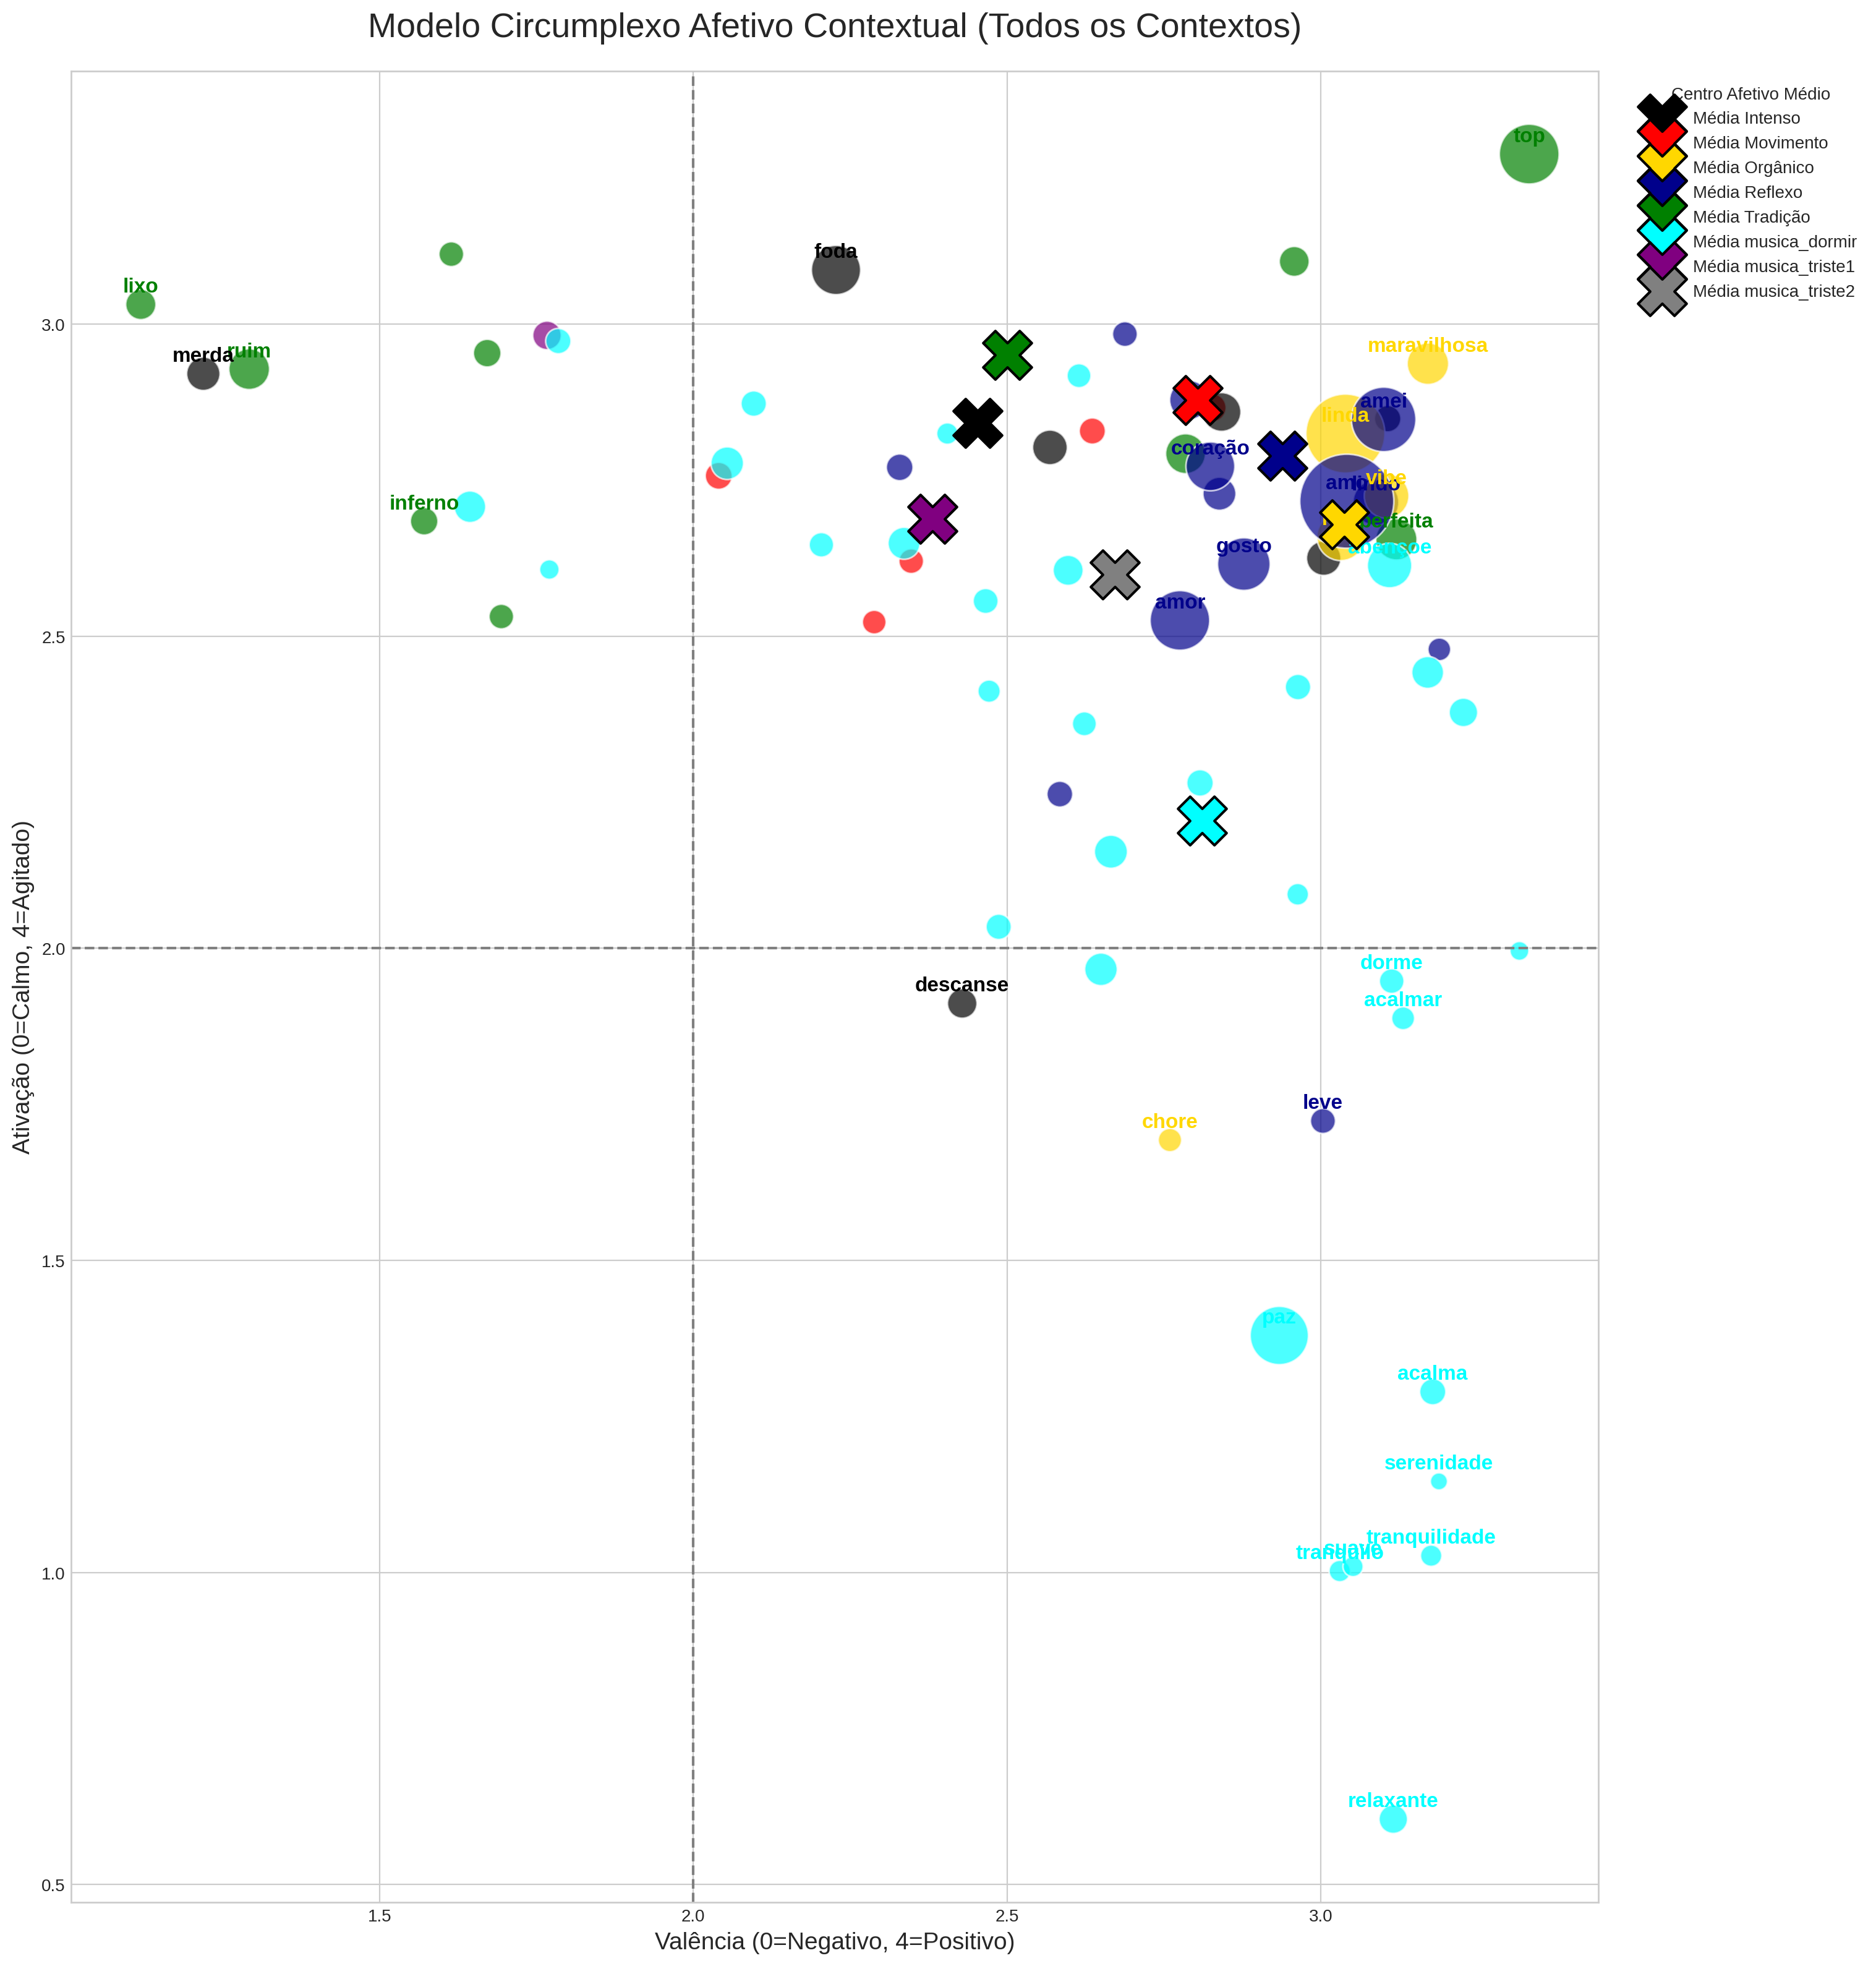

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supondo que 'df_plot_final' e 'df_perfil_afetivo_final' j√° foram criados.

# --- PASSO 1: ATUALIZAR O DICION√ÅRIO DE CORES ---
# Adicionar entradas para os novos contextos de baixa ativa√ß√£o.
# Vamos escolher cores que se encaixem, por exemplo, tons de roxo e ciano.

cores_personalizadas = {
    # Fatores RITMO
    'Movimento': 'red',
    'Reflexo': 'darkblue',
    'Tradi√ß√£o': 'green',
    'Intenso': 'black',
    'Org√¢nico': 'gold',

    # Novos Contextos de Baixa Ativa√ß√£o
    'musica_triste1': 'purple',
    'musica_dormir': 'cyan',
    'lofi_relax': 'cyan'
}


# --- PASSO 2: VISUALIZA√á√ÉO COM JITTER (O c√≥digo a partir daqui √© o mesmo) ---
print("\nGerando o gr√°fico final com a paleta de cores completa...")

# Adicionar "jitter"
jitter_strength = 0.08
df_plot_final['valencia_jitter'] = df_plot_final['valencia'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))
df_plot_final['ativacao_jitter'] = df_plot_final['ativacao'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_plot_final))

# Configurar o gr√°fico
fig, ax = plt.subplots(figsize=(18, 16))
plt.style.use('seaborn-v0_8-whitegrid')

# PLOTAR OS PONTOS COM JITTER E A NOVA PALETA
sns.scatterplot(
    data=df_plot_final,
    x='valencia_jitter',
    y='ativacao_jitter',
    hue='fator',
    palette=cores_personalizadas, # Agora ele encontrar√° todas as chaves
    size='frequencia',
    sizes=(100, 3000),
    alpha=0.7,
    ax=ax,
    legend=False
)

# ANOTAR DE FORMA INTELIGENTE
for index, row in df_plot_final.iterrows():
    if row['frequencia'] > df_plot_final['frequencia'].quantile(0.80) or \
       row['valencia'] < 1.5 or row['valencia'] > 3.5 or \
       row['ativacao'] < 2.0 or row['ativacao'] > 3.5:
        ax.text(
            x=row['valencia_jitter'], y=row['ativacao_jitter']+0.02, s=row['palavra'],
            fontdict=dict(
                color=cores_personalizadas.get(row['fator'], 'gray'),
                size=12, weight='bold', ha='center'
            )
        )

# Plotar os centros de gravidade
for index, row in df_perfil_afetivo_final.iterrows():
    fator_nome = row['fator_ritmo']
    ax.scatter(
        x=row['valencia_zs'], y=row['ativacao_zs'], marker='X', s=800,
        color=cores_personalizadas.get(fator_nome, 'gray'),
        edgecolor='black', linewidth=1.5, zorder=10,
        label=f'M√©dia {fator_nome}'
    )

# Configura√ß√µes finais e legenda
ax.axvline(x=2, color='gray', linestyle='--')
ax.axhline(y=2, color='gray', linestyle='--')
ax.set_xlabel('Val√™ncia (0=Negativo, 4=Positivo)', fontsize=14)
ax.set_ylabel('Ativa√ß√£o (0=Calmo, 4=Agitado)', fontsize=14)
ax.set_title('Modelo Circumplexo Afetivo Contextual (Todos os Contextos)', fontsize=20, pad=20)
ax.legend(title='Centro Afetivo M√©dio', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


Gerando o gr√°fico simplificado (sem fatores)...


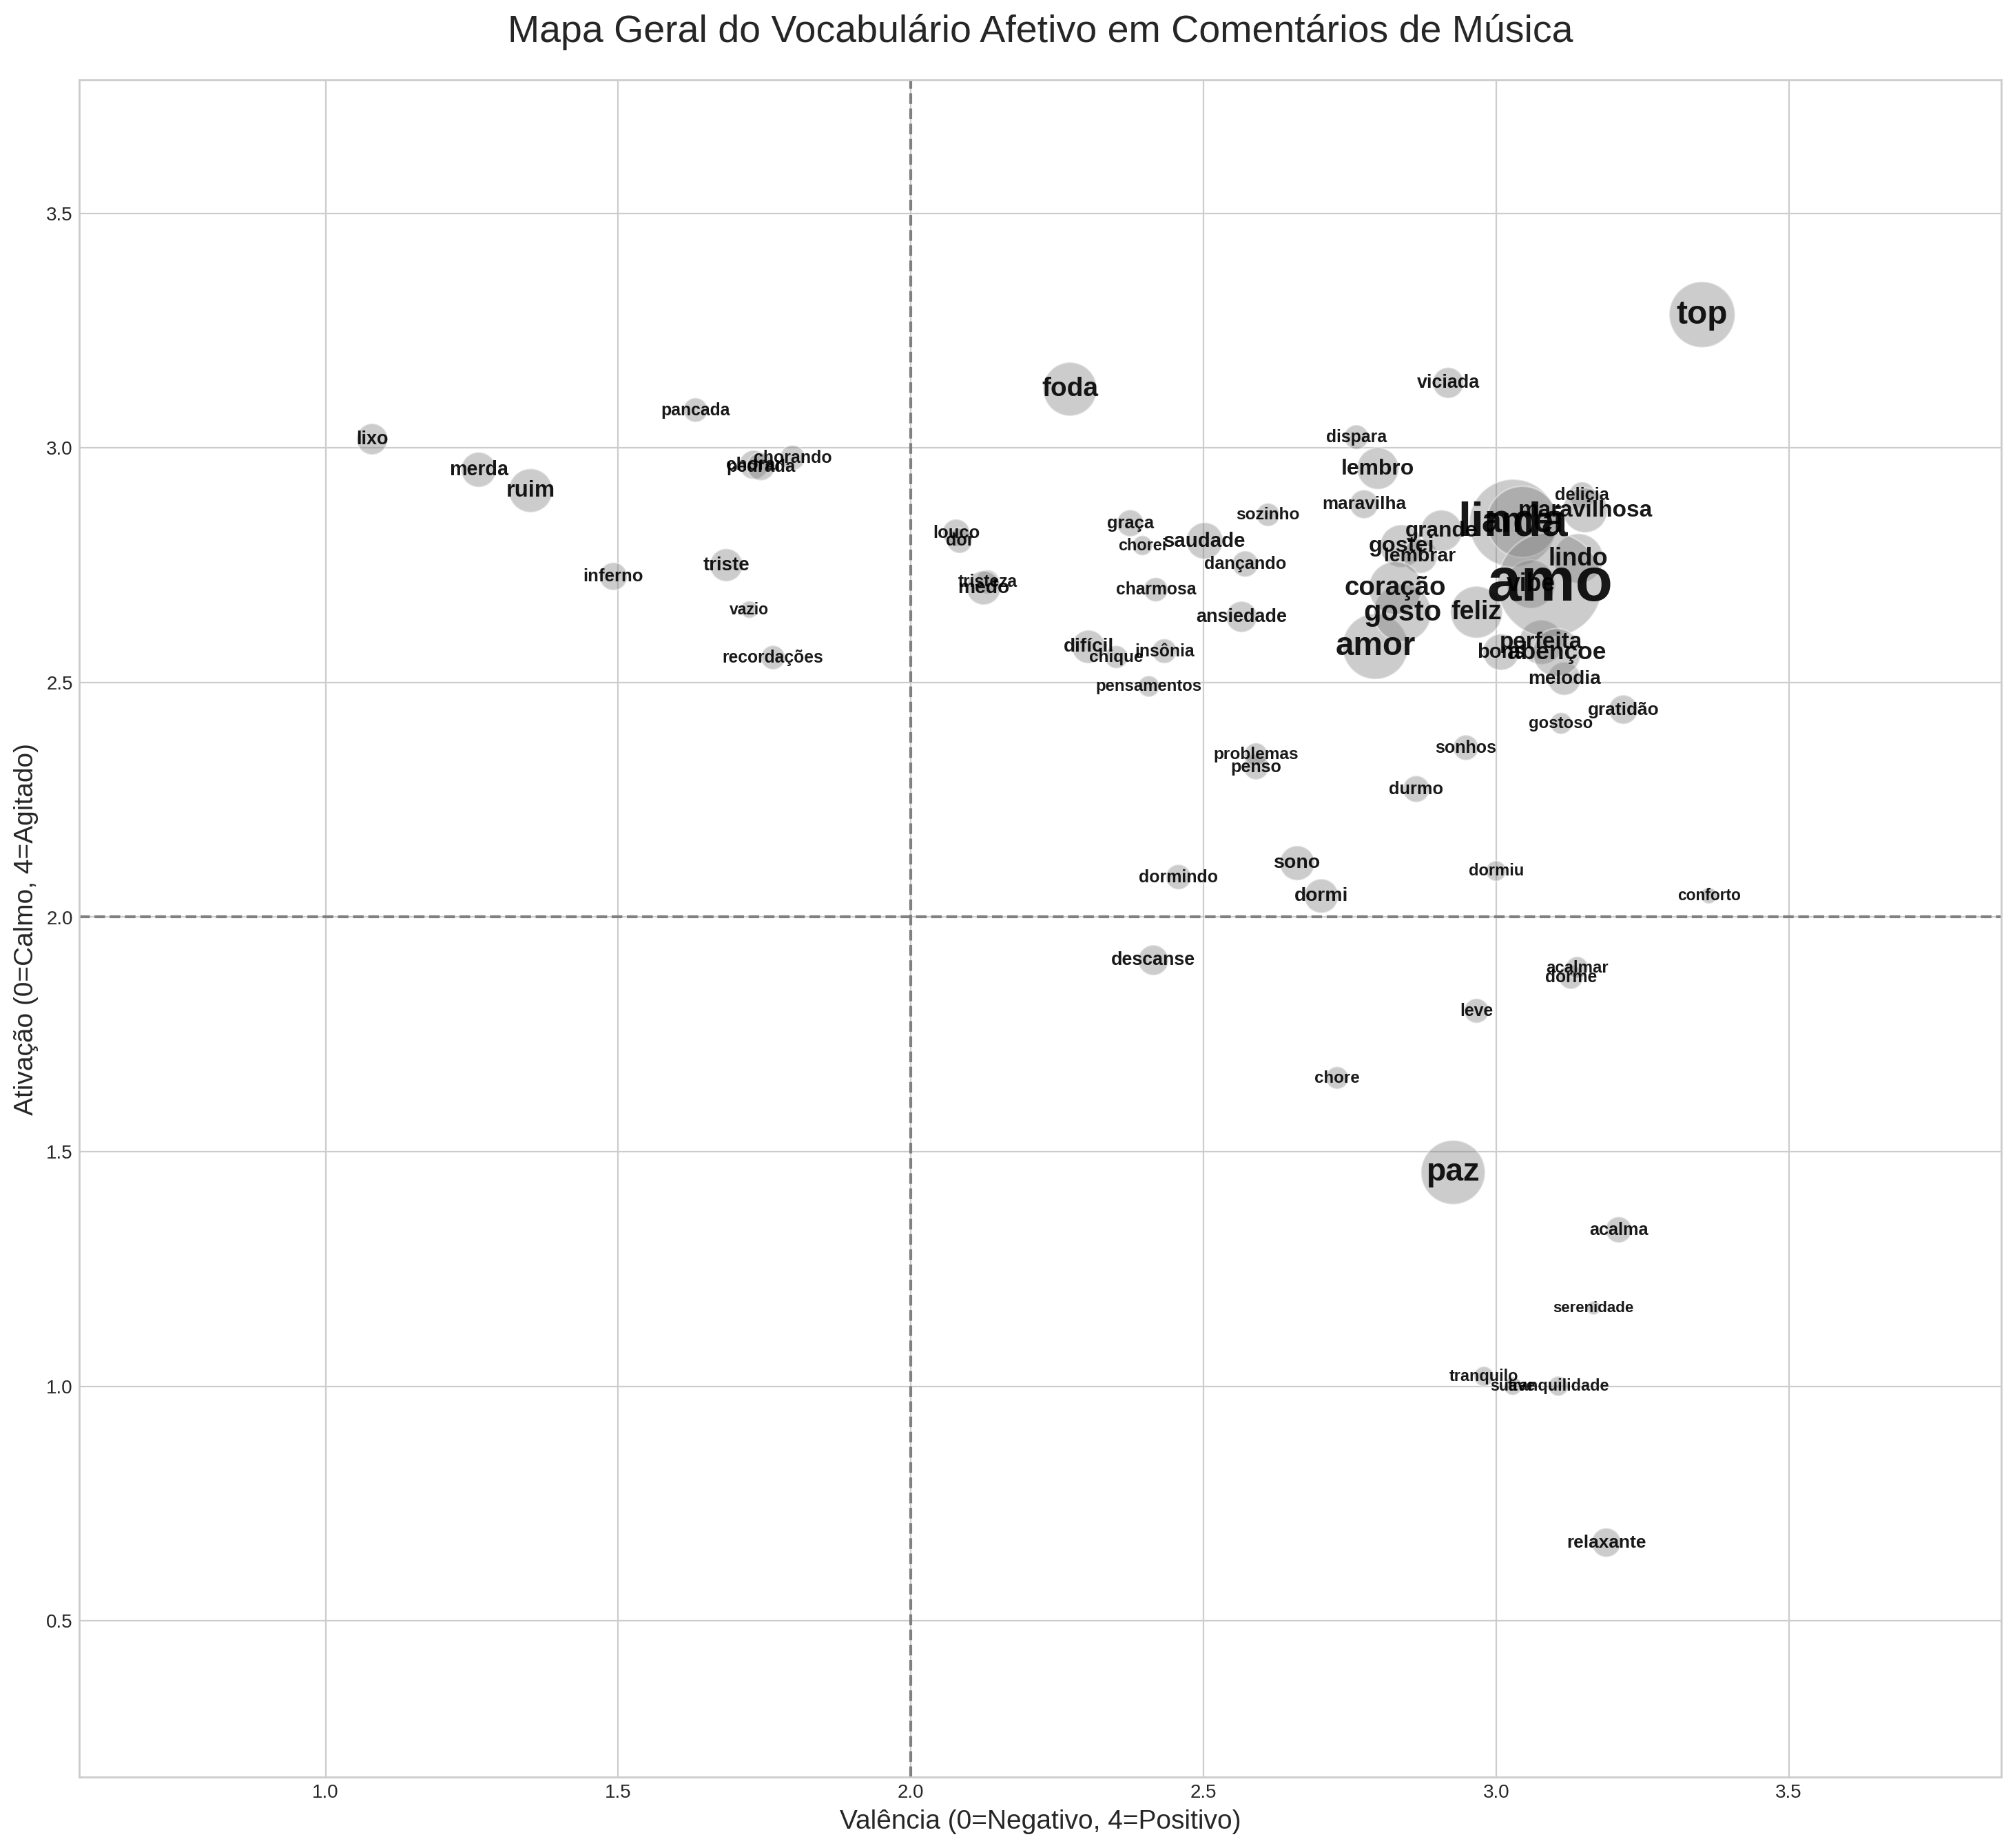

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================================================================
# PR√â-REQUISITO:
# O DataFrame 'df_plot_final' (ou 'df_plot_zs', dependendo de como voc√™ o nomeou)
# j√° deve ter sido criado, contendo as colunas: 'palavra', 'frequencia', 'valencia', 'ativacao'.
# ==============================================================================

print("\nGerando o gr√°fico simplificado (sem fatores)...")

# --- PASSO 1: Definir os dados a serem plotados ---
# N√£o precisamos modificar o DataFrame, apenas a forma como o plotamos.
df_para_plot_geral = df_plot_final.copy() # Usando o DataFrame que j√° temos

# --- PASSO 2: VISUALIZA√á√ÉO GERAL E LIMPA ---
fig, ax = plt.subplots(figsize=(18, 16))
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Plotar os pontos de fundo (as bolhas) em uma √∫nica cor
sns.scatterplot(
    data=df_para_plot_geral,
    x='valencia', # Usar as colunas originais, sem jitter
    y='ativacao',
    size='frequencia',
    sizes=(50, 3000),
    color='gray', # Cor √∫nica para todos os pontos
    alpha=0.4,
    ax=ax,
    legend=False # Sem legenda
)

# 2. Adicionar o texto das palavras com tamanho din√¢mico e cor √∫nica
freq_min, freq_max = df_para_plot_geral['frequencia'].min(), df_para_plot_geral['frequencia'].max()
tamanho_min_fonte, tamanho_max_fonte = 8, 32

for index, row in df_para_plot_geral.iterrows():
    tamanho_fonte = np.interp(row['frequencia'], [freq_min, freq_max], [tamanho_min_fonte, tamanho_max_fonte])
    ax.text(
        x=row['valencia'], y=row['ativacao'], s=row['palavra'],
        fontdict=dict(
            color='black', # Cor √∫nica para todo o texto
            size=tamanho_fonte,
            weight='bold',
            ha='center',
            va='center'
        ),
        alpha=0.9
    )

# 3. Configura√ß√µes finais do gr√°fico (sem legenda de fatores)
ax.axvline(x=2, color='gray', linestyle='--')
ax.axhline(y=2, color='gray', linestyle='--')
ax.set_xlabel('Val√™ncia (0=Negativo, 4=Positivo)', fontsize=14)
ax.set_ylabel('Ativa√ß√£o (0=Calmo, 4=Agitado)', fontsize=14)
ax.set_title('Mapa Geral do Vocabul√°rio Afetivo em Coment√°rios de M√∫sica', fontsize=20, pad=20)

# Definir limites para um bom enquadramento
ax.set_xlim(df_para_plot_geral['valencia'].min() - 0.5, df_para_plot_geral['valencia'].max() + 0.5)
ax.set_ylim(df_para_plot_geral['ativacao'].min() - 0.5, df_para_plot_geral['ativacao'].max() + 0.5)

plt.show()

In [ ]:
import pandas as pd

# ==============================================================================
# PR√â-REQUISITO:
# O DataFrame 'df_plot_final' j√° deve ter sido criado, contendo as coordenadas
# m√©dias de val√™ncia e ativa√ß√£o para cada palavra-chave.
# ==============================================================================

print("--- Verificando o Quadrante Inferior Esquerdo (Baixa Val√™ncia e Baixa Ativa√ß√£o) ---")

# Definir os limites do quadrante
# Usamos o ponto central (2,2) como refer√™ncia da nossa escala 0-4
limite_valencia = 2.0
limite_ativacao = 2.0

try:
    # Filtrar o DataFrame para encontrar palavras que atendem a AMBAS as condi√ß√µes
    quadrante_inferior_esquerdo = df_plot_final[
        (df_plot_final['valencia'] < limite_valencia) &
        (df_plot_final['ativacao'] < limite_ativacao)
    ]

    # Verificar o resultado da filtragem
    if quadrante_inferior_esquerdo.empty:
        # Se o DataFrame resultante estiver vazio, n√£o encontramos nenhuma palavra.
        print("\nRESULTADO: Nenhuma palavra foi encontrada no quadrante inferior esquerdo.")
        print(f"(Condi√ß√µes: Val√™ncia < {limite_valencia} E Ativa√ß√£o < {limite_ativacao})")
        print("\nIsso confirma a observa√ß√£o visual de que este quadrante afetivo √© pouco utilizado nos coment√°rios de m√∫sica analisados.")
    else:
        # Se encontrarmos alguma palavra, vamos exibi-la.
        print(f"\nRESULTADO: Foram encontradas {len(quadrante_inferior_esquerdo)} palavra(s) no quadrante inferior esquerdo:")

        # Renomear colunas para clareza
        quadrante_inferior_esquerdo_formatado = quadrante_inferior_esquerdo.rename(columns={
            'fator': 'Fator Dominante',
            'palavra': 'Palavra-Chave',
            'frequencia': 'Frequ√™ncia',
            'valencia': 'Val√™ncia M√©dia (0-4)',
            'ativacao': 'Ativa√ß√£o M√©dia (0-4)'
        }).round(2) # Arredondar valores

        display(quadrante_inferior_esquerdo_formatado.sort_values(by='Frequ√™ncia', ascending=False))

except NameError:
    print("\nERRO: O DataFrame 'df_plot_final' n√£o foi encontrado.")
    print("Por favor, execute a etapa de prepara√ß√£o para o gr√°fico primeiro.")
except KeyError:
    print("\nERRO: Certifique-se de que as colunas 'valencia' e 'ativacao' existem no DataFrame.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado: {e}")

--- Verificando o Quadrante Inferior Esquerdo (Baixa Val√™ncia e Baixa Ativa√ß√£o) ---

RESULTADO: Nenhuma palavra foi encontrada no quadrante inferior esquerdo.
(Condi√ß√µes: Val√™ncia < 2.0 E Ativa√ß√£o < 2.0)

Isso confirma a observa√ß√£o visual de que este quadrante afetivo √© pouco utilizado nos coment√°rios de m√∫sica analisados.
